#Importación de Librerias

In [ ]:
# Subir documento con el nombre "gob_chats.txt"
!pip install pandas
!pip install openpyxl
!pip install geopy
!pip install fuzzywuzzy
!pip install requests
!pip install cdsapi
!pip install contextily

In [ ]:
import ast
import cdsapi
import os
import re
import pandas as pd
import time
import random
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from datetime import datetime, timedelta
from fuzzywuzzy import fuzz
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, \
    OneHotEncoder
from sklearn.model_selection import train_test_split, \
    cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

/usr/local/lib/python3.12/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Importación de Datos

In [ ]:
geotest_df = pd.read_csv('servicios.csv')

In [ ]:
geotest_df.head()

FECHA      HORA                      UBICACION
0  2023-10-26  22:28:00                            NaN
1  2023-10-26  22:34:00  PARA VALORIZACION DE FEMENINA
2  2023-10-26  23:17:00                            NaN
3  2023-10-27  00:28:00                            NaN
4  2023-10-27  01:44:00                            NaN

## Se observa la inicial del dataset:
### Se muestran número de registros, los tipos de datos y los posibles valores faltantes.

In [ ]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18673 entries, 0 to 18672
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FECHA      18673 non-null  object
 1   HORA       18673 non-null  object
 2   UBICACION  16990 non-null  object
dtypes: object(3)
memory usage: 437.8+ KB


## Se eliminan filas con valores faltantes.
### Esto debido a que el enfoque principal del proyecto es la predicción de coordenadas, por lo que es más conveniente deshacernos de las incompletas que completar la información faltante por medio de promedios u otras tecnicas alternativas

In [ ]:
geotest_df = geotest_df.dropna()

In [ ]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16990 entries, 1 to 18667
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FECHA      16990 non-null  object
 1   HORA       16990 non-null  object
 2   UBICACION  16990 non-null  object
dtypes: object(3)
memory usage: 530.9+ KB


In [ ]:
# Se crea la columna 'COORDENADAS'
geotest_df['COORDENADAS'] = geotest_df.get('COORDENADAS')

In [ ]:
geotest_df.shape

(16990, 4)

In [ ]:
geotest_df.head()

FECHA      HORA                                          UBICACION  \
1  2023-10-26  22:34:00                      PARA VALORIZACION DE FEMENINA   
5  2023-10-27  08:09:00  MANANTIAL 507 LAGO       COLONIA    EL MANANTI...   
6  2023-10-27  08:19:00  ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN  ...   
7  2023-10-27  08:41:00  CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...   
8  2023-10-27  09:10:00  ELIAS FLORES SUR GARZA GARCIA OTE           CO...   

  COORDENADAS  
1        None  
5        None  
6        None  
7        None  
8        None

In [ ]:
geotest_df.tail()

FECHA      HORA  \
18663  2025-05-12  00:13:00   
18664  2025-05-12  02:21:00   
18665  2025-05-12  04:01:00   
18666  2025-05-12  06:30:00   
18667  2025-05-12  07:54:00   

                                               UBICACION COORDENADAS  
18663  RIO GUADIANA RIO PARAGUAY  RIO PARAGUAY 845 25...        None  
18664  E 6A SAN FELIPE  Colonia  VALLE DE SAN ANDRES ...        None  
18665  VALLE DEL MAIZ 835         Colonia  VALLE DE L...        None  
18666  BOSQUE NOGAL BOSQUE PALMITO  25 72327  100 158...        None  
18667  SOLO LE MENCIONAN QUE SE SIENTE MAL REQUIERE A...        None

## Se convierte ubicación a coordenada
### Se utiliza un api para procesar las ubicaciones y convertirlas a coordenadas y exportandolo a 'geotest_backup.csv'

In [ ]:
# Configurar geolocalizador
GOOGLE_API_KEY = "APIKEY"
BACKUP_FILE = "servicios.csv"
REQUEST_DELAY = 0.1
BACKUP_INTERVAL = 50

start_time = time.time()
counter = 0
total_addresses = len(geotest_df)


# Palabras irrelevantes o ruido
STOPWORDS = [
    r"\bCOLONIA\b", r"\bCORRODENAADAS\b", r"\bCOORDENADAS\b",
    r"\bAPODACA\b", r"\bNL\b", r"\bMUNICIPIO\b", r"\bIGLESIA\b",
    r"\bFOM\b", r"\bKM\b", r"\bPUENTE\b", r"\bPUEBLO\b"
]


def limpiar_direccion(direccion: str) -> str:
    for palabra in STOPWORDS:
        direccion = re.sub(palabra, '', direccion, flags=re.IGNORECASE)
    direccion = re.sub(r'\s+', ' ', direccion).strip()
    direccion = re.sub(r'[^\w\s#\-,]', '', direccion).strip(', ')
    if 'apodaca' not in direccion.lower():
        direccion += ', Apodaca, Nuevo León, México'
    elif 'nuevo león' not in direccion.lower():
        direccion += ', Nuevo León, México'
    elif 'méxico' not in direccion.lower():
        direccion += ', México'
    return direccion


def reducir_direccion(direccion: str, nivel: int) -> str:
    partes = direccion.split(', ')
    return ', '.join(partes[nivel:]) if len(partes) > nivel else direccion


# API

def geocodificar_google(direccion: str) -> dict | None:
    """Devuelve {'lat': float, 'lon': float} o None si no se encuentra."""
    url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": direccion, "key": GOOGLE_API_KEY}
    respuesta = requests.get(url, params=params)
    datos = respuesta.json()
    if datos.get('results'):
        ubicacion = datos['results'][0]['geometry']['location']
        return {'lat': ubicacion['lat'], 'lon': ubicacion['lng']}
    return None


def geocodificar_direccion(direccion, coord_existente, folio, counter, total):
    """Limpia, intenta con diferentes niveles y guarda progreso."""
    if coord_existente not in [None, (None, None)]:
        return coord_existente, counter

    resultado = None
    try:
        direccion_limpia = limpiar_direccion(direccion)
        for nivel in range(3):
            consulta = reducir_direccion(direccion_limpia, nivel)
            resultado = geocodificar_google(consulta)
            if resultado:
                break
        if not resultado:
            print(f"No se encontró coincidencia para {folio}: '{direccion}'")
    except Exception as e:
        print(f"Error en el folio {folio}: {e}")

    counter += 1
    print(f"{counter}/{total} procesados: {resultado}")

    # Guardar respaldo y progreso cada cierto número de registros
    if counter % BACKUP_INTERVAL == 0:
        transcurrido = time.time() - start_time
        tiempo_promedio = transcurrido / counter
        restante = total - counter
        tiempo_estimado = tiempo_promedio * restante
        print(f"Progreso: {counter}/{total} | "
              f"Tiempo estimado restante: {tiempo_estimado / 60:.1f} min")
        geotest_df.to_csv(BACKUP_FILE, index=False)
        print("Respaldo guardado.")

    time.sleep(REQUEST_DELAY)
    return resultado, counter


def aplicar_geocodificacion(fila):
    global counter
    coordenadas, counter = geocodificar_direccion(
        fila['UBICACION'],
        fila.get('COORDENADAS', None),
        fila.get('FOLIO', fila['UBICACION']),
        counter,
        total_addresses
    )
    return coordenadas


geotest_df['COORDENADAS'] = geotest_df.apply(aplicar_geocodificacion, axis=1)

geotest_df.to_csv(BACKUP_FILE, index=False)
print("Geocodificación finalizada. Archivo de respaldo guardado.")

Streaming output truncated to the last 5000 lines.
✅ Coordenada para folio TREVINO 1095        COLONIA  CENTRO DE APODACA APODACA NL: {'lat': 25.7789998, 'lon': -100.2004012}
✅ Coordenada para folio LMTO NOROESTE E KM 35 544  CORRODENAADAS  25 83111  100 25400   COLONIA  MUNICIPIO DE APODACA APODACA NL   IGLESIA CENTRO MUNDIAL DE ORACION: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio JAPON 203   COLONIA  NUEVO AMANECER 2 APODACA NL: {'lat': 25.7715892, 'lon': -100.2463403}
✅ Coordenada para folio AV TREBOLES AV 7A        COLONIA  LOS TREBOLES APODACA NL: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio BOLIVIA 106       COLONIA    NUEVO AMANECER 1 APODACA NL: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio AV NUEVA LAS PUENTES ZINC        COLONIA  AV NUEVA LAS PUENTES ZINC: {'lat': 25.7871006, 'lon': -100.1850769}
✅ Coordenada para folio CTO CLIO ALAYA  CTO CLIO 225       COLONIA  PRIVALIA CONCORDIA 1 APODACA NL: {'lat': 25.7871006, '

# Expansión de variables

### Se importa base de datos con coordenadas a 'serviciosGoogle.csv'

In [ ]:
# geotest_coordinates = pd.read_csv('serviciosGoogle.csv')

In [ ]:
geotest_coordinates.head()

FECHA      HORA                                          UBICACION  \
0  2023-10-26  22:34:00                      PARA VALORIZACION DE FEMENINA   
1  2023-10-27  08:09:00  MANANTIAL 507 LAGO       COLONIA    EL MANANTI...   
2  2023-10-27  08:19:00  ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN  ...   
3  2023-10-27  08:41:00  CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...   
4  2023-10-27  09:10:00  ELIAS FLORES SUR GARZA GARCIA OTE           CO...   

                                COORDENADAS  
0   {'lat': 25.776468, 'lon': -100.1858743}  
1   {'lat': 25.783571, 'lon': -100.2646878}  
2  {'lat': 25.7817301, 'lon': -100.1683529}  
3  {'lat': 25.7963812, 'lon': -100.2151901}  
4   {'lat': 25.7805964, 'lon': -100.180686}

## Se divide COORDENADAS en LATITUD y LONGITUD

In [ ]:
# Se convierte el diccionario stringified de COORDENADAS a diccionarios reales
geotest_coordinates["COORDENADAS"] = geotest_coordinates["COORDENADAS"].apply(
    ast.literal_eval)

# Se divide en LATITUD y LONGITUD
geotest_coordinates["LATITUD"] = geotest_coordinates["COORDENADAS"].apply(
    lambda x: x.get("lat") if isinstance(x, dict) else None)
geotest_coordinates["LONGITUD"] = geotest_coordinates["COORDENADAS"].apply(
    lambda x: x.get("lon") if isinstance(x, dict) else None)

# Se convierten a númericos
geotest_coordinates["LATITUD"] = pd.to_numeric(geotest_coordinates["LATITUD"])
geotest_coordinates["LONGITUD"] = pd.to_numeric(geotest_coordinates["LONGITUD"])

geotest_coordinates.head()

FECHA      HORA                                          UBICACION  \
0  2023-10-26  22:34:00                      PARA VALORIZACION DE FEMENINA   
1  2023-10-27  08:09:00  MANANTIAL 507 LAGO       COLONIA    EL MANANTI...   
2  2023-10-27  08:19:00  ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN  ...   
3  2023-10-27  08:41:00  CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...   
4  2023-10-27  09:10:00  ELIAS FLORES SUR GARZA GARCIA OTE           CO...   

                                COORDENADAS    LATITUD    LONGITUD  
0   {'lat': 25.776468, 'lon': -100.1858743}  25.776468 -100.185874  
1   {'lat': 25.783571, 'lon': -100.2646878}  25.783571 -100.264688  
2  {'lat': 25.7817301, 'lon': -100.1683529}  25.781730 -100.168353  
3  {'lat': 25.7963812, 'lon': -100.2151901}  25.796381 -100.215190  
4   {'lat': 25.7805964, 'lon': -100.180686}  25.780596 -100.180686

In [ ]:
# Imprimir información del nuevo dataframe
geotest_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16990 entries, 0 to 16989
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        16990 non-null  object 
 1   HORA         16990 non-null  object 
 2   UBICACION    16990 non-null  object 
 3   COORDENADAS  16990 non-null  object 
 4   LATITUD      16990 non-null  float64
 5   LONGITUD     16990 non-null  float64
dtypes: float64(2), object(4)
memory usage: 796.5+ KB


In [ ]:
# Se realiza un conteo de las 10 coordenadas más repetidas en el dataset.
coord_repetidas = (
    geotest_coordinates
    .value_counts(subset=['LATITUD', 'LONGITUD'])
    .reset_index(name='repeticiones')
    .sort_values('repeticiones', ascending=False)
)

coord_repetidas = coord_repetidas[coord_repetidas['repeticiones'] > 1]

print("Coordenadas más repetidas (Top 10):")
display(coord_repetidas.head(10))

Coordenadas más repetidas (Top 10):


LATITUD    LONGITUD  repeticiones
0  25.776468 -100.185874           579
1  25.781606 -100.188633           202
2  25.776991 -100.182889           148
3  25.715301 -100.153170           127
4  25.795130 -100.242964           117
5  25.754213 -100.141196           116
6  25.800425 -100.239586           114
7  25.724636 -100.193287           109
8  25.788556 -100.145267           103
9  25.816008 -100.244591            99

In [ ]:
geotest_coordinates['COORDENADAS'] = geotest_coordinates['COORDENADAS'].astype(
    str)
geotest_coordinates.to_csv("serviciosGoogle.csv", index=False, encoding='utf-8')

## Puntos Dentro de Apodaca

### Se Gráfica Apodaca

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.1 MB/s eta 0:00:00
                                            geometry   bbox_west  bbox_south  \
0  POLYGON ((-100.27276 25.84942, -100.27096 25.8... -100.272761   25.694126   

    bbox_east  bbox_north   place_id  osm_type   osm_id        lat  \
0 -100.101036   25.879285  291778061  relation  5605520  25.787101   

          lon     class            type  place_rank  importance addresstype  \
0 -100.185077  boundary  administrative          12    0.318696      county   

      name                 display_name  
0  Apodaca  Apodaca, Nuevo León, Mexico  


<Axes: >

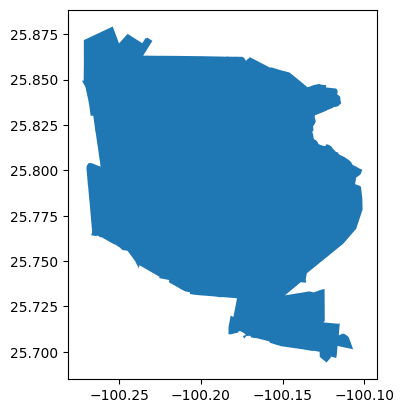

In [ ]:
!pip install osmnx
import geopandas as gpd
import osmnx as ox

apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")

print(apodaca)
apodaca.plot()

### Se filtran los filtros que estan fuera de Apodaca

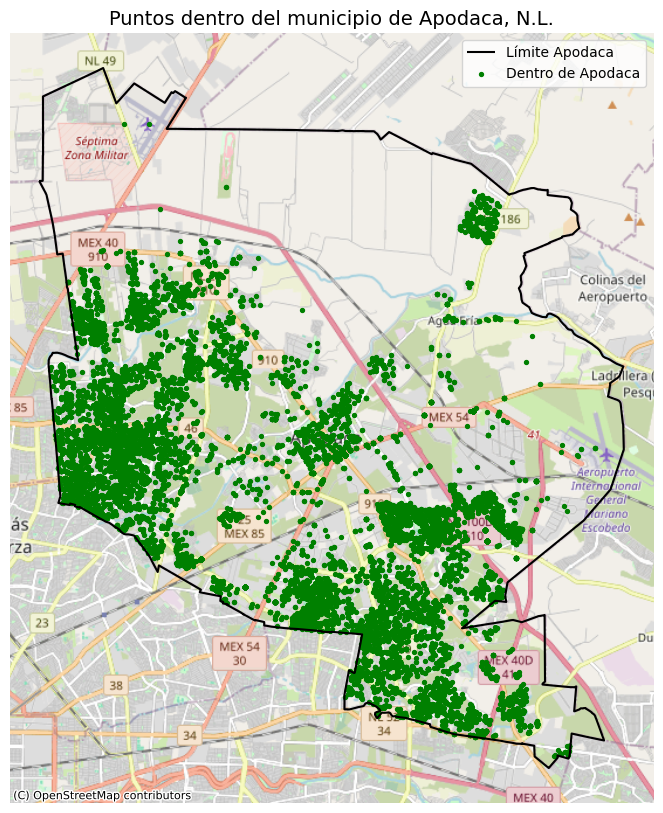

In [ ]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import contextily as ctx

# --- 1. Copiar y limpiar coordenadas ---
df = geotest_coordinates.copy()

# Filtrar coordenadas dentro de México
df = df[
    df['LATITUD'].between(14, 33) &
    df['LONGITUD'].between(-118, -86)
].dropna(subset=['LATITUD', 'LONGITUD'])

# --- 2. Crear geometría (x = LONGITUD, y = LATITUD) ---
df['geometry'] = [Point(xy) for xy in zip(df['LONGITUD'], df['LATITUD'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

# --- 3. Obtener polígono de Apodaca ---
apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")

# --- 4. Filtrar solo puntos dentro del municipio ---
gdf = gdf[gdf.within(apodaca.loc[0, 'geometry'])]

# --- 5. Convertir a proyección métrica para usar mapa base ---
gdf_web = gdf.to_crs(epsg=3857)
apodaca_web = apodaca.to_crs(epsg=3857)

# --- 6. Graficar solo puntos dentro ---
fig, ax = plt.subplots(figsize=(10, 10))
apodaca_web.boundary.plot(ax=ax, color='black', linewidth=1.5, label='Límite Apodaca')
gdf_web.plot(ax=ax, color='green', markersize=8, label='Dentro de Apodaca')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Puntos dentro del municipio de Apodaca, N.L.", fontsize=14)
ax.legend()
ax.set_axis_off()

plt.show()

In [ ]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point

df = geotest_coordinates.copy()

# Filtrar coordenadas dentro del rango geográfico de México
df = df[
    df['LATITUD'].between(14, 33) &
    df['LONGITUD'].between(-118, -86)
].dropna(subset=['LATITUD', 'LONGITUD'])

df['geometry'] = [Point(xy) for xy in zip(df['LONGITUD'], df['LATITUD'])]
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")

gdf['DENTRO_APODACA'] = gdf.within(apodaca.loc[0, 'geometry'])

gdf_dentro = gdf[gdf['DENTRO_APODACA']].copy()
df_limpio = gdf_dentro.drop(columns=['geometry', 'DENTRO_APODACA']).reset_index(
    drop=True)


total_original = len(gdf)
total_dentro = len(gdf_dentro)
total_fuera = total_original - total_dentro
porc_dentro = (total_dentro / total_original) * 100
porc_fuera = (total_fuera / total_original) * 100

print(f"originales: {total_original}")
print(f"dentro de Apodaca: {total_dentro} ({porc_dentro:.2f}%)")
print(f"fuera de Apodaca: {total_fuera} ({porc_fuera:.2f}%)")

display(df_limpio.head())

originales: 16959
dentro de Apodaca: 16304 (96.14%)
fuera de Apodaca: 655 (3.86%)


FECHA      HORA                                          UBICACION  \
0  2023-10-26  22:34:00                      PARA VALORIZACION DE FEMENINA   
1  2023-10-27  08:09:00  MANANTIAL 507 LAGO       COLONIA    EL MANANTI...   
2  2023-10-27  08:19:00  ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN  ...   
3  2023-10-27  08:41:00  CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...   
4  2023-10-27  09:10:00  ELIAS FLORES SUR GARZA GARCIA OTE           CO...   

                                COORDENADAS    LATITUD    LONGITUD  
0   {'lat': 25.776468, 'lon': -100.1858743}  25.776468 -100.185874  
1   {'lat': 25.783571, 'lon': -100.2646878}  25.783571 -100.264688  
2  {'lat': 25.7817301, 'lon': -100.1683529}  25.781730 -100.168353  
3  {'lat': 25.7963812, 'lon': -100.2151901}  25.796381 -100.215190  
4   {'lat': 25.7805964, 'lon': -100.180686}  25.780596 -100.180686

In [ ]:
df_limpio.to_csv("serviciosGoogleSoloApodaca.csv", index=False, encoding='utf-8')

## Se expande la fecha y la hora en subconjuntos

In [ ]:
geotest_coordinates = df_limpio.copy()

geotest_coordinates["FECHA"] = geotest_coordinates["FECHA"].astype(str).str.strip()
geotest_coordinates["HORA"] = geotest_coordinates["HORA"].astype(str).str.strip()

# Se convierte fecha y hora en los formatos adecuados
geotest_coordinates["FECHA_dt"] = pd.to_datetime(
    geotest_coordinates["FECHA"], format="%Y-%m-%d", errors="coerce")
mask = geotest_coordinates["FECHA_dt"].isna()
geotest_coordinates.loc[mask, "FECHA_dt"] = pd.to_datetime(
    geotest_coordinates.loc[mask, "FECHA"], dayfirst=True, errors="coerce")

geotest_coordinates["HORA_td"] = pd.to_timedelta(geotest_coordinates["HORA"], errors="coerce")

geotest_coordinates["DT"] = geotest_coordinates["FECHA_dt"] + geotest_coordinates["HORA_td"]
geotest_coordinates = geotest_coordinates.dropna(subset=["DT"]).reset_index(
    drop=True)

# Se redondea a 15 mins en columna nueva
geotest_coordinates["DT_15"] = geotest_coordinates["DT"].dt.round("15min")

# Se generan subvariables
geotest_coordinates["FECHA"] = geotest_coordinates["DT_15"].dt.date
geotest_coordinates["HORA_15"] = geotest_coordinates["DT_15"].dt.strftime(
    "%H:%M")  # label like "10:15"
geotest_coordinates["HORA_H"] = geotest_coordinates["DT_15"].dt.hour  # 0..23
geotest_coordinates["WEEKDAY"] = geotest_coordinates["DT_15"].dt.dayofweek  # 0=Mon .. 6=Sun
weekday_map = {0: "Lun", 1: "Mar", 2: "Mié", 3: "Jue", 4: "Vie", 5: "Sáb", 6: "Dom"}
geotest_coordinates["WEEKDAY_NAME"] = geotest_coordinates["WEEKDAY"].map(
    weekday_map)


slots = pd.date_range("00:00", "23:45", freq="15min").strftime("%H:%M")
geotest_coordinates["HORA_15"] = pd.Categorical(
    geotest_coordinates["HORA_15"], categories=slots, ordered=True)

geotest_coordinates["MIN_DESDE_MEDIANOCHE"] = geotest_coordinates["DT_15"].dt.hour * 60 + geotest_coordinates["DT_15"].dt.minute

In [ ]:
geotest_coordinates["FECHA"] = geotest_coordinates["FECHA"].astype(str).str.strip()
geotest_coordinates["HORA"]  = geotest_coordinates["HORA"].astype(str).str.strip()

# Se convierte fecha y hora en los formatos adecuados
geotest_coordinates["FECHA_dt"] = pd.to_datetime(geotest_coordinates["FECHA"], format="%Y-%m-%d", errors="coerce")
mask = geotest_coordinates["FECHA_dt"].isna()
geotest_coordinates.loc[mask, "FECHA_dt"] = pd.to_datetime(geotest_coordinates.loc[mask, "FECHA"], dayfirst=True, errors="coerce")

geotest_coordinates["HORA_td"] = pd.to_timedelta(geotest_coordinates["HORA"], errors="coerce")

geotest_coordinates["DT"] = geotest_coordinates["FECHA_dt"] + geotest_coordinates["HORA_td"]
geotest_coordinates = geotest_coordinates.dropna(subset=["DT"]).reset_index(drop=True)

# Se redondea a 15 mins en columna nueva
geotest_coordinates["DT_15"] = geotest_coordinates["DT"].dt.round("15min")

# Se generan subvariables
geotest_coordinates["FECHA"]        = geotest_coordinates["DT_15"].dt.date
geotest_coordinates["HORA_15"]      = geotest_coordinates["DT_15"].dt.strftime("%H:%M")      # label like "10:15"
geotest_coordinates["HORA_H"]       = geotest_coordinates["DT_15"].dt.hour                   # 0..23
geotest_coordinates["WEEKDAY"]      = geotest_coordinates["DT_15"].dt.dayofweek              # 0=Mon .. 6=Sun
weekday_map = {0:"Lun",1:"Mar",2:"Mié",3:"Jue",4:"Vie",5:"Sáb",6:"Dom"}
geotest_coordinates["WEEKDAY_NAME"] = geotest_coordinates["WEEKDAY"].map(weekday_map)


slots = pd.date_range("00:00", "23:45", freq="15min").strftime("%H:%M")
geotest_coordinates["HORA_15"] = pd.Categorical(geotest_coordinates["HORA_15"], categories=slots, ordered=True)

geotest_coordinates["MIN_DESDE_MEDIANOCHE"] = geotest_coordinates["DT_15"].dt.hour*60 + geotest_coordinates["DT_15"].dt.minute


In [ ]:
geotest_coordinates.head()

FECHA      HORA                                          UBICACION  \
0  2023-10-26  22:34:00                      PARA VALORIZACION DE FEMENINA   
1  2023-10-27  08:09:00  MANANTIAL 507 LAGO       COLONIA    EL MANANTI...   
2  2023-10-27  08:19:00  ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN  ...   
3  2023-10-27  08:41:00  CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...   
4  2023-10-27  09:10:00  ELIAS FLORES SUR GARZA GARCIA OTE           CO...   

                                COORDENADAS    LATITUD    LONGITUD   FECHA_dt  \
0   {'lat': 25.776468, 'lon': -100.1858743}  25.776468 -100.185874 2023-10-26   
1   {'lat': 25.783571, 'lon': -100.2646878}  25.783571 -100.264688 2023-10-27   
2  {'lat': 25.7817301, 'lon': -100.1683529}  25.781730 -100.168353 2023-10-27   
3  {'lat': 25.7963812, 'lon': -100.2151901}  25.796381 -100.215190 2023-10-27   
4   {'lat': 25.7805964, 'lon': -100.180686}  25.780596 -100.180686 2023-10-27   

          HORA_td                  DT               DT_15 HORA_15  HORA_H  \
0 0 days 22:34:00 2023-10-26 22:34:00 2023-10-26 22:30:00   22:30      22   
1 0 days 08:09:00 2023-10-27 08:09:00 2023-10-27 08:15:00   08:15       8   
2 0 days 08:19:00 2023-10-27 08:19:00 2023-10-27 08:15:00   08:15       8   
3 0 days 08:41:00 2023-10-27 08:41:00 2023-10-27 08:45:00   08:45       8   
4 0 days 09:10:00 2023-10-27 09:10:00 2023-10-27 09:15:00   09:15       9   

   WEEKDAY WEEKDAY_NAME  MIN_DESDE_MEDIANOCHE  
0        3          Jue                  1350  
1        4          Vie                   495  
2        4          Vie                   495  
3        4          Vie                   525  
4        4          Vie                   555

In [ ]:
geotest_coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16304 entries, 0 to 16303
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   FECHA                 16304 non-null  object         
 1   HORA                  16304 non-null  object         
 2   UBICACION             16304 non-null  object         
 3   COORDENADAS           16304 non-null  object         
 4   LATITUD               16304 non-null  float64        
 5   LONGITUD              16304 non-null  float64        
 6   FECHA_dt              16304 non-null  datetime64[ns] 
 7   HORA_td               16304 non-null  timedelta64[ns]
 8   DT                    16304 non-null  datetime64[ns] 
 9   DT_15                 16304 non-null  datetime64[ns] 
 10  HORA_15               16304 non-null  category       
 11  HORA_H                16304 non-null  int32          
 12  WEEKDAY               16304 non-null  int32          
 13  W

## Se exporta base expandida a 'geotest_w_coordinates.csv'

In [ ]:
geotest_coordinates.to_csv('geotest_w_coordinates.csv', index=False)
# Confirm the save operation
print("geotest_coordinates saved successfully.")

geotest_coordinates saved successfully.


# Gráficas exploratoria de Datos

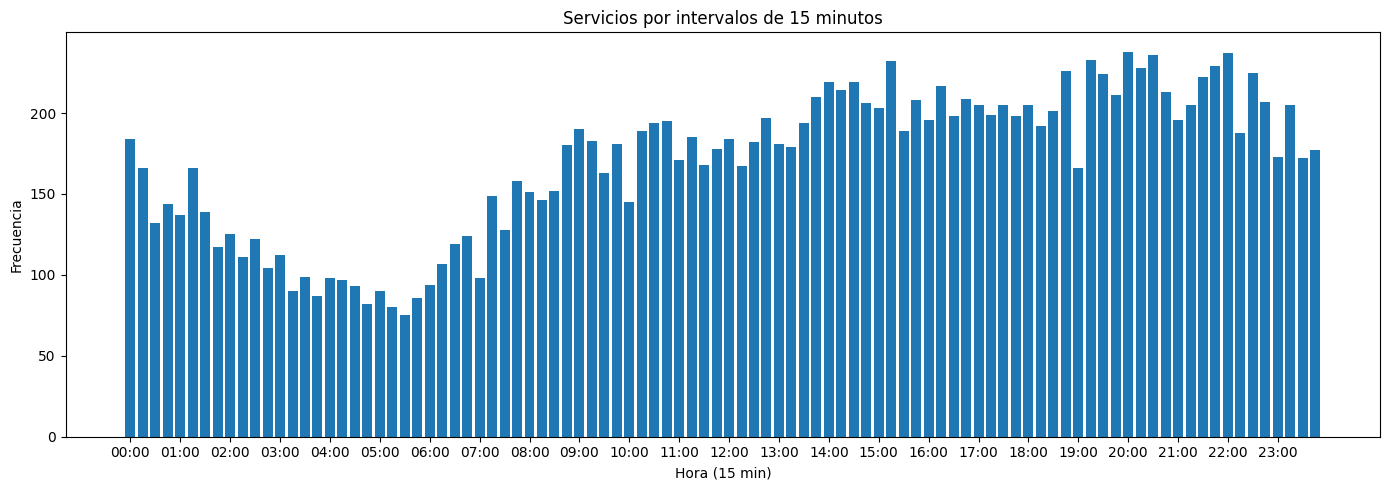

In [ ]:
counts_15 = geotest_coordinates["HORA_15"].value_counts().sort_index()
ticks = np.arange(0, 96, 4)

plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(counts_15)), counts_15.values)
plt.title("Servicios por intervalos de 15 minutos")
plt.xlabel("Hora (15 min)")
plt.ylabel("Frecuencia")
plt.xticks(ticks, slots[ticks], rotation=0)
plt.tight_layout()
plt.show()

**Observaciones:**

* Intervalos de mayor despacho: Entre las 20:00 y 22:00, lo que sugiere una posible correlación con la vida nocturna, el tráfico o actividades de fin de día.

* Punto más bajo: Alrededor de las 05:00, consistente con los periodos de menor actividad humana.

* Alta demanda a partir de las 12:00: Esto implica que la planificación de recursos debe enfocarse fuertemente desde el mediodía hasta la noche.

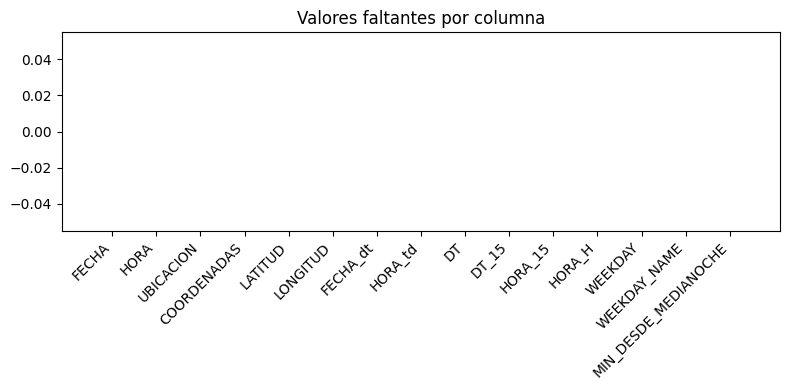

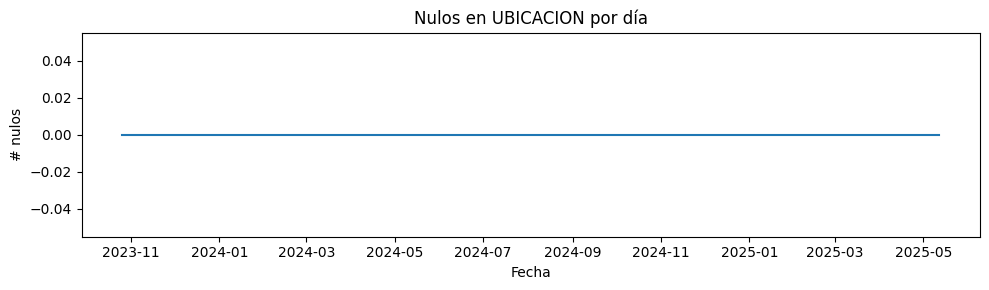

In [ ]:
# Conteo de nulos por columna
na_counts = geotest_coordinates.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
plt.bar(na_counts.index, na_counts.values)
plt.title("Valores faltantes por columna")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Mapa de ausencia por día (nulos en UBICACION como ejemplo)
by_day_na = geotest_coordinates.set_index("DT_15").resample("D")["UBICACION"].apply(
    lambda s: s.isna().sum())
plt.figure(figsize=(10, 3))
plt.plot(by_day_na.index, by_day_na.values)
plt.title("Nulos en UBICACION por día")
plt.xlabel("Fecha")
plt.ylabel("# nulos")
plt.tight_layout()
plt.show()

**Observaciones**

Se pude observar que no hay valores nulos presentes en el dataset.

            LATITUD      LONGITUD  MIN_DESDE_MEDIANOCHE
count  16304.000000  16304.000000          16304.000000
mean      25.768008   -100.201358            799.440935
std        0.031009      0.041241            401.203365
min       25.697412   -100.269660              0.000000
25%       25.743560   -100.242964            510.000000
50%       25.771298   -100.193401            840.000000
75%       25.788556   -100.166146           1140.000000
max       25.864608   -100.109465           1425.000000


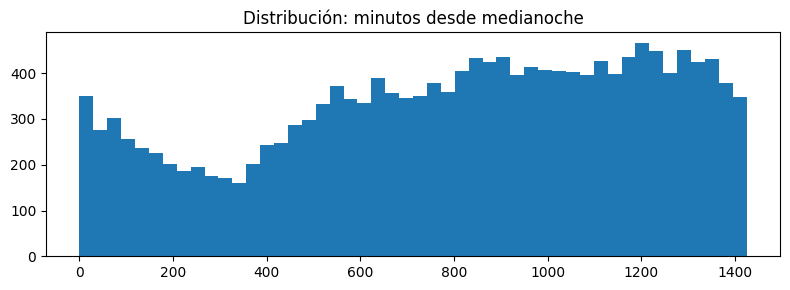

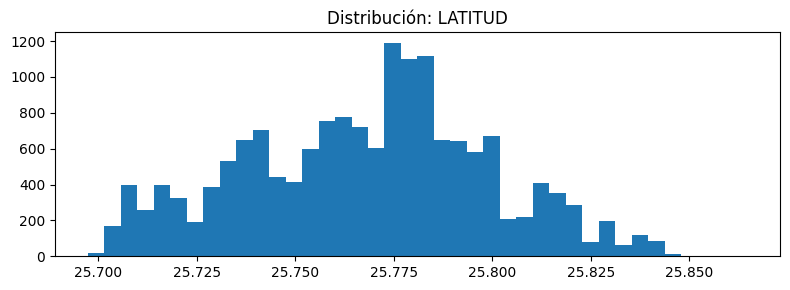

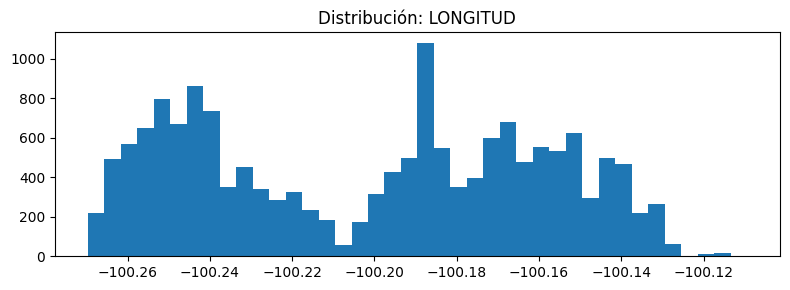

In [ ]:
# Resumen numérico rápido
print(geotest_coordinates[["LATITUD", "LONGITUD", "MIN_DESDE_MEDIANOCHE"]].describe())

# Histogramas simples
plt.figure(figsize=(8, 3))
plt.hist(geotest_coordinates["MIN_DESDE_MEDIANOCHE"], bins=48)
plt.title("Distribución: minutos desde medianoche")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(geotest_coordinates["LATITUD"], bins=40)
plt.title("Distribución: LATITUD")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(geotest_coordinates["LONGITUD"], bins=40)
plt.title("Distribución: LONGITUD")
plt.tight_layout()
plt.show()

**Observaciones**

**Distribución: Minutos desde media noche**
- Baja actividad: entre las 04:00 y 06:00 (240–360 minutos).

- Aumento brusco: la frecuencia se eleva con fuerza después de las 06:00.

- Demanda sostenida: desde aproximadamente las 10:00 hasta las 23:00.

- Pico de actividad: entre las 18:00 y 22:00, con las frecuencias más altas superando los 150 despachos.

**Distribución: Latitud**
- Pico muy pronunciado: alrededor de 25.78°, con casi 700 incidentes, lo que indica un gran punto crítico.

- Picos secundarios: presentes en las latitudes de 25.74–25.76° y 25.81°.

- Distribución no uniforme: los despachos no se distribuyen de manera homogénea a lo largo de la latitud, sino que están altamente concentrados en una franja estrecha.

**Distribución: Longitud**
- Clúster 1: Entre −100.26 y −100.23, con más de 400 llamadas por intervalo, probablemente correspondiente al núcleo urbano o región central.

- Clúster 2: Entre −100.18 y −100.14, también con un volumen significativo de llamadas.

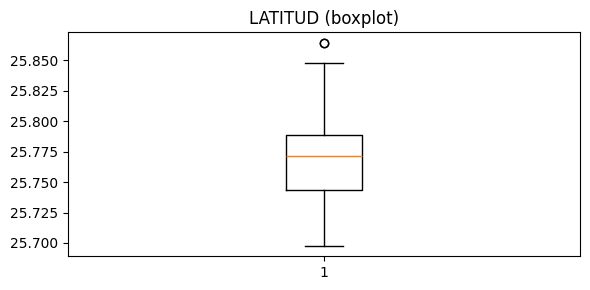

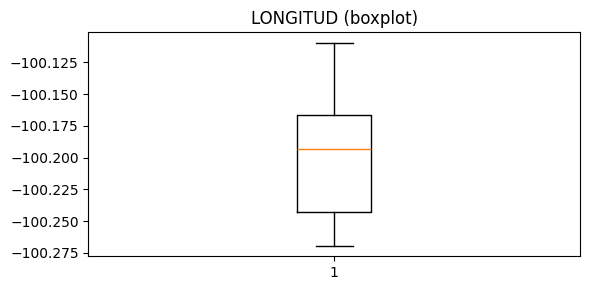

In [ ]:
plt.figure(figsize=(6, 3))
plt.boxplot(geotest_coordinates["LATITUD"].dropna())
plt.title("LATITUD (boxplot)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.boxplot(geotest_coordinates["LONGITUD"].dropna())
plt.title("LONGITUD (boxplot)")
plt.tight_layout()
plt.show()

**Observaciones**

**LATITUD**
- Distribución más compacta: la dispersión de los despachos en la dirección norte–sur es más reducida que la de la longitud.

- Latitud mediana: aproximadamente 25.78, lo que coincide con el pico principal identificado en el histograma anterior.

- Rango e IQR: indican que la mayoría de los servicios se concentran en una franja vertical estrecha, probablemente correspondiente a un solo municipio o cinturón urbano.

**LONGITUD**
- Longitud central: alrededor de −100.20, donde ocurre la mayor parte de los despachos, lo que sugiere un centro geográfico de la actividad.

- Dispersión intercuartílica (IQR): moderadamente amplia, lo que indica cierta variación en la dirección este-oeste, aunque la concentración principal se mantiene.

- Sin valores atípicos visibles: la distribución parece bastante compacta alrededor de las zonas urbanas.


In [ ]:
def iqr_outliers(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (s < lo) | (s > hi)

out_lat = iqr_outliers(geotest_coordinates["LATITUD"])
out_lon = iqr_outliers(geotest_coordinates["LONGITUD"])
df_out = geotest_coordinates[out_lat | out_lon]
print("Posibles outliers geográficos:", len(df_out))

Posibles outliers geográficos: 2


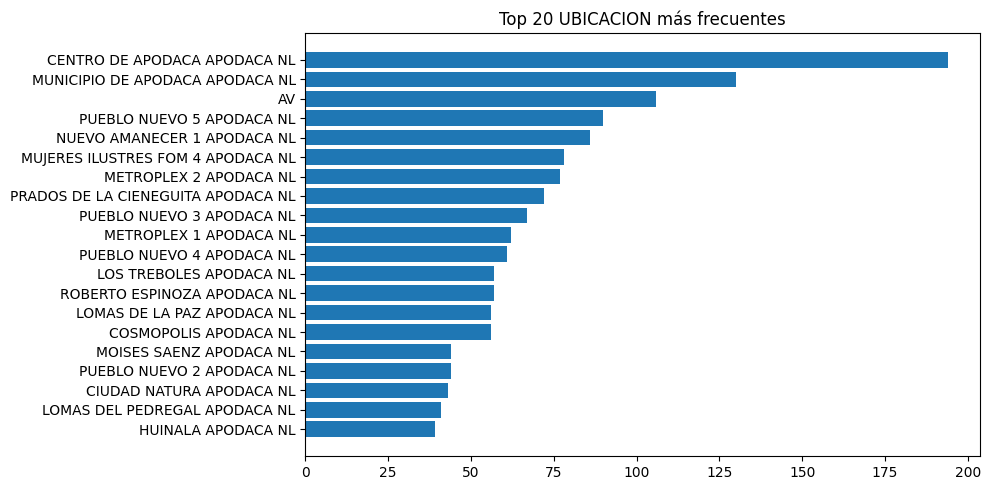

In [ ]:
# Top ubicaciones (direcciones repetidas) – ajusta N según convenga
topN = 20
counts_ubi = geotest_coordinates["UBICACION"].value_counts().head(topN)

plt.figure(figsize=(10, 5))
plt.barh(counts_ubi.index[::-1], counts_ubi.values[::-1])
plt.title(f"Top {topN} UBICACION más frecuentes")
plt.tight_layout()
plt.show()

**Observaciones**

**Ubicaciones más frecuentes:**
  - Centro de Apodaca (~195 servicios)
  - Municipio de Apodaca (~130 servicios)
- Estas zonas destacan claramente sobre el resto en cuanto a volumen de actividad.
- Puede existir una oportunidad para revisar distribución de recursos para balancear carga o mejorar cobertura en otras zonas menos atendidas.



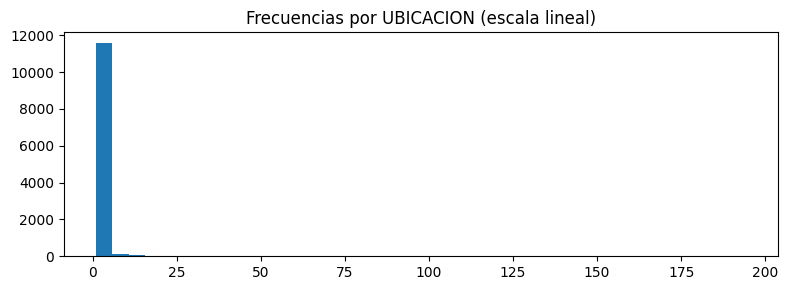

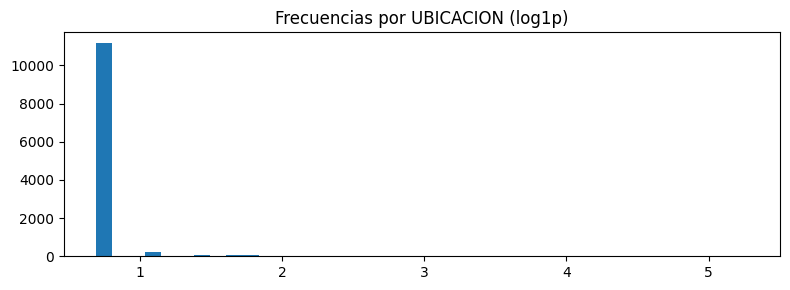

In [ ]:
freq = geotest_coordinates["UBICACION"].value_counts()
plt.figure(figsize=(8, 3))
plt.hist(freq.values, bins=40)
plt.title("Frecuencias por UBICACION (escala lineal)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(np.log1p(freq.values), bins=40)
plt.title("Frecuencias por UBICACION (log1p)")
plt.tight_layout()
plt.show()

**Observaciones**
- Concentración Geográfica: La mayoría de los servicios ocurren en zonas específicas de Apodaca, NL, destacando la celda (25.7801, -100.2504) como principal hotspot.

- Ubicaciones Dominantes: CENTRO DE APODACA y MUNICIPIO DE APODACA son las ubicaciones con más servicios. La mayoría de ubicaciones aparecen muy pocas veces (distribución sesgada).

- Horario Pico: La mayor actividad ocurre entre 19:00 y 21:00 hrs. Las mañanas y madrugadas tienen menor volumen de servicios.

- Disminución Reciente: A partir de julio 2024 se observa una caída significativa en el número de servicios diarios.

- Distribución Espacial Irregular: Pocas celdas concentran gran parte de los servicios. La mayoría tiene baja frecuencia.

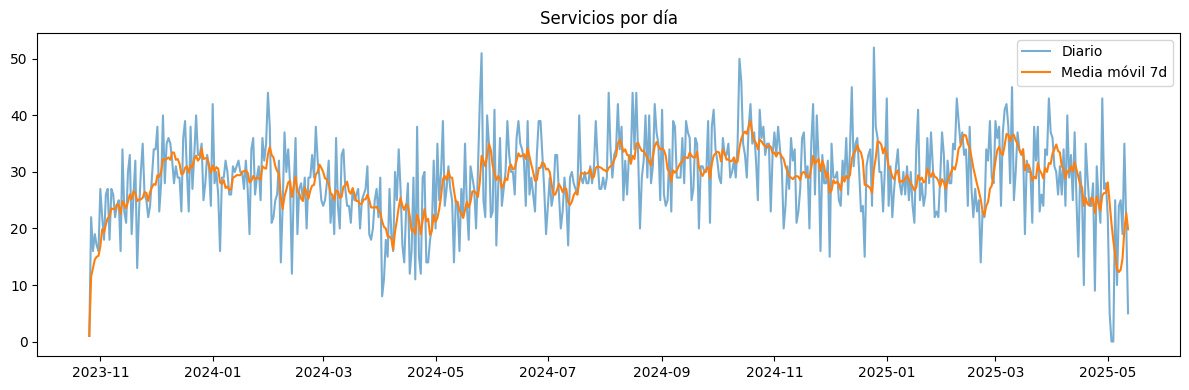

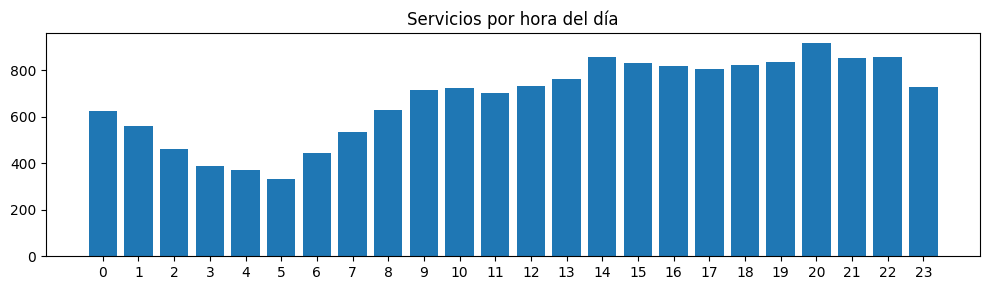

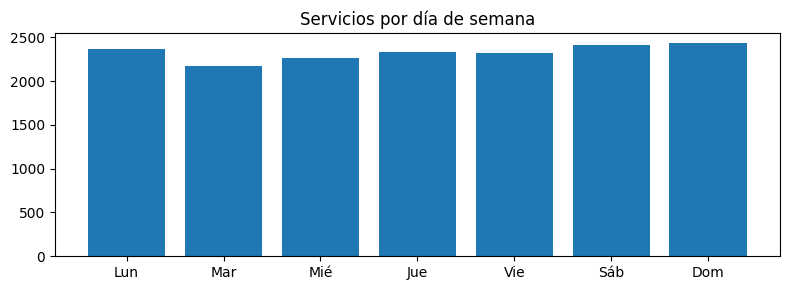

In [ ]:
# Conteos diarios + media móvil 7d
daily = geotest_coordinates.set_index("DT_15").resample("D").size()
roll7 = daily.rolling(7, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily.values, label="Diario", alpha=0.6)
plt.plot(roll7.index, roll7.values, label="Media móvil 7d")
plt.title("Servicios por día")
plt.legend()
plt.tight_layout()
plt.show()

# Perfil por hora (24 barras)
hour_counts = geotest_coordinates["HORA_H"].value_counts().sort_index()
plt.figure(figsize=(10, 3))
plt.bar(hour_counts.index, hour_counts.values)
plt.title("Servicios por hora del día")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

# Estacionalidad semanal (promedio por weekday)
wk = geotest_coordinates.groupby("WEEKDAY_NAME").size().reindex(
    ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"])
plt.figure(figsize=(8, 3))
plt.bar(np.arange(len(wk)), wk.values)
plt.title("Servicios por día de semana")
plt.xticks(np.arange(len(wk)), wk.index)
plt.tight_layout()
plt.show()

**Servicios por día**

**1. Se presentan tres diferentes fases operacionales:**

**Fase 1 | Hasta Jun 2024**

- Los picos diarios suelen superar los 25–30.

- El promedio móvil se mantiene estable entre 15–20.

- Volatilidad alta, con gran variabilidad en la frecuencia.

**Fase 2 | Jul 2024 – Oct 2024**

- Descenso marcado en la actividad.

- El promedio móvil cae por debajo de 5.

- Algunos días registran actividad cercana a cero.

- Posible interrupción de datos o baja estacional.

**Fase 3 | Nov 2024 – May 2025**

- Actividad baja pero con tendencia a aumentar gradualmente.

- El promedio móvil fluctúa entre 3 y 8.

- Aún se presentan picos, aunque menos frecuentes e intensos.

**2. Ventana de máxima actividad**

- A finales de 2023 a inicios de 2024 (noviembre–marzo) es el periodo más ocupado.

- Los valores diarios superan regularmente los 25, lo que sugiere una demanda sostenida de servicios de emergencia durante esta temporada.



**Servicios por hora del día**

- Picos principales entre las 20:00 y 22:00 horas, con un máximo claro alrededor de las 20:00.
- Caída notable en la madrugada (03:00–06:00), coincidiendo con los valores más bajos.
- A partir de las 07:00 inicia un ascenso constante en actividad, manteniéndose alto desde las 09:00 hasta las 22:00.
- Esto sugiere que la demanda de servicios está fuertemente concentrada en la tarde y noche.


**Servicios por día de la semana**

- Distribución de cantidad de servicios despachados relativamente uniforme a lo largo de la semana.
- Domingo y Lunes presentan la mayor cantidad de servicios.

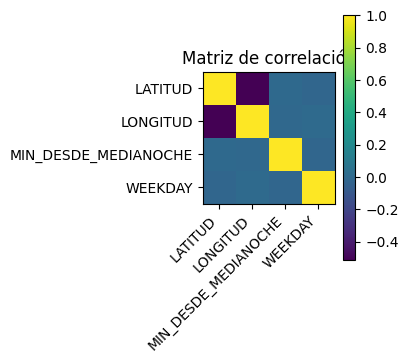

In [ ]:
num = geotest_coordinates[["LATITUD", "LONGITUD", "MIN_DESDE_MEDIANOCHE", "WEEKDAY"]].dropna()
corr = num.corr()

plt.figure(figsize=(4, 4))
plt.imshow(corr.values, aspect="equal")
plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha="right")
plt.yticks(range(corr.shape[1]), corr.columns)
plt.title("Matriz de correlación")
plt.colorbar()
plt.tight_layout()
plt.show()

**Observaciones**

- Relación más fuerte: entre latitud y longitud, lo que indica direccionalidad geográfica. Esto probablemente refleja una expansión urbana lineal o la concentración de despachos a lo largo de un corredor.

- Correlación tiempo–día de la semana: existe un vínculo moderado entre la hora del día y el día de la semana, posiblemente asociado a diferencias de horarios entre días laborales y fines de semana.

- Independencia de factores espaciales y temporales: los datos confirman que la ubicación de los despachos es mayormente independiente del tiempo y del día, lo que refuerza que el despliegue basado en ubicación debe mantenerse estable durante toda la semana.

/tmp/ipython-input-1085290084.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = (geotest_coordinates.pivot_table(index="WEEKDAY_NAME", columns="HORA_15",


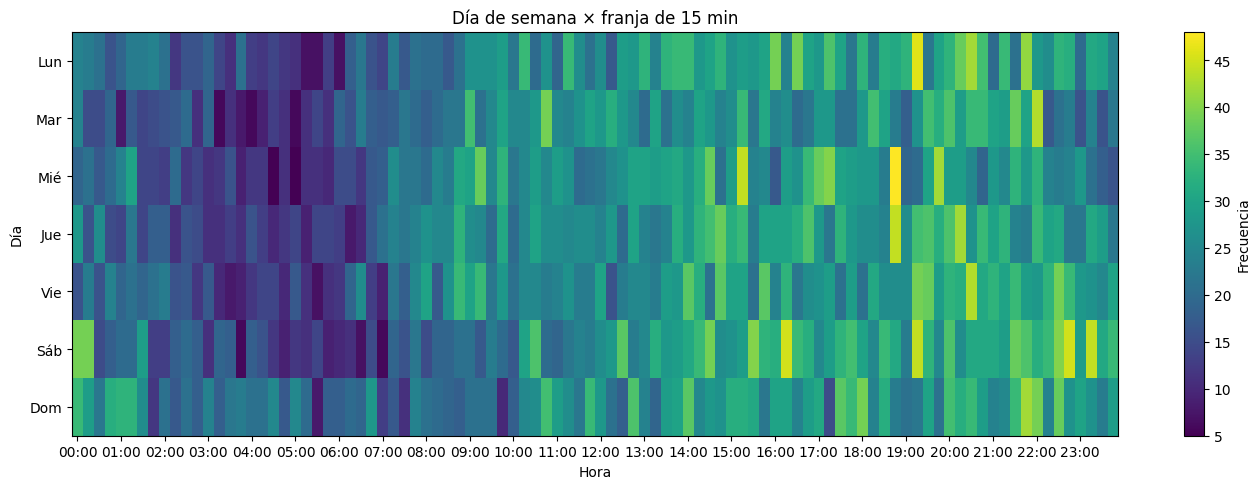

In [ ]:
slots = pd.date_range("00:00", "23:45", freq="15min").strftime("%H:%M")
pivot = (geotest_coordinates.pivot_table(index="WEEKDAY_NAME", columns="HORA_15",
                                         values="FECHA", aggfunc="size", fill_value=0)
         .reindex(index=["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"])
         .reindex(columns=slots))

plt.figure(figsize=(14, 5))
im = plt.imshow(pivot.values, aspect="auto", origin="upper")
plt.title("Día de semana × franja de 15 min")
plt.xlabel("Hora")
plt.ylabel("Día")
ticks = np.arange(0, 96, 4)
plt.xticks(ticks, slots[ticks])
plt.yticks(range(7), pivot.index)
plt.colorbar(im, label="Frecuencia")
plt.tight_layout()
plt.show()

**Observaciones**

- Sábado: día con mayor intensidad de despachos, especialmente en la tarde y noche.

- Domingo: destacan los picos en la madrugada, lo que sugiere necesidad de cobertura extendida en el turno nocturno.

- Tarde-noche: franja consistentemente ocupada todos los días, lo que refuerza la importancia de mantener personal suficiente en ese horario.

- La volumen de despachos depende más de la hora del día que del día de la semana, aunque los fines de semana presentan ventanas más largas de alta demanda.

/tmp/ipython-input-1360144327.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"], showfliers=False)


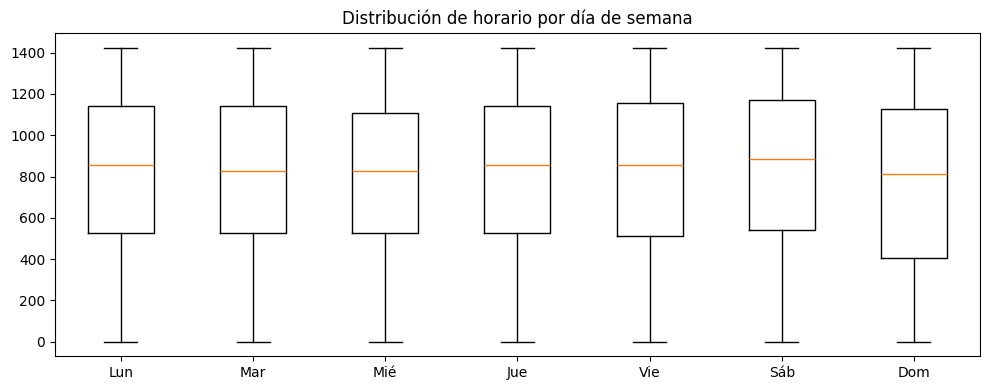

In [ ]:
data = [geotest_coordinates.loc[geotest_coordinates["WEEKDAY_NAME"] == d, "MIN_DESDE_MEDIANOCHE"]
        for d in ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]]
plt.figure(figsize=(10, 4))
plt.boxplot(data, tick_labels=["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"],
            showfliers=False)
plt.title("Distribución de horario por día de semana")
plt.tight_layout()
plt.show()

**Observaciones**

1. El sábado destaca:

- Mediana de despacho más tardía (~15:40).

- IQR superior más amplio → los despachos se extienden más tarde en la noche que cualquier otro día.

- Coincide con el heatmap: el sábado concentra la mayor actividad en horas vespertinas/nocturnas.

2. El domingo es más disperso:

- Presenta el bigote inferior y la mediana más tempranos (~12:50).

- Indica que más despachos ocurren temprano en el día, probablemente asociados a la actividad posterior al sábado por la noche.

3. Entre semana (lun–vie) son uniformes:

- Medianas similares (~13:30–14:30).

- Los despachos están bien distribuidos a lo largo del día.

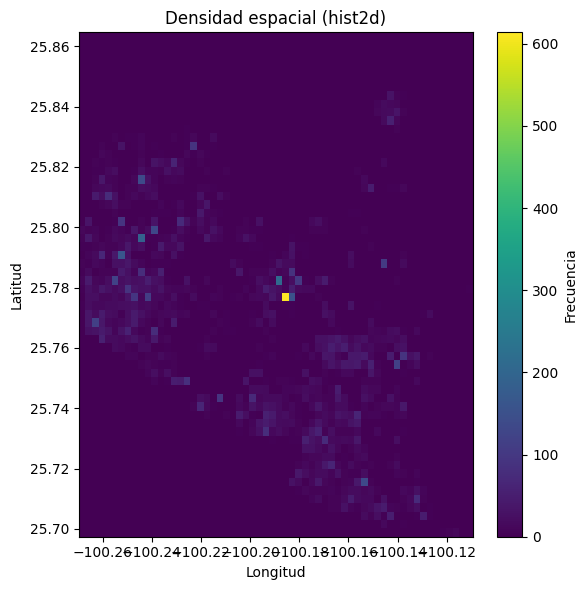

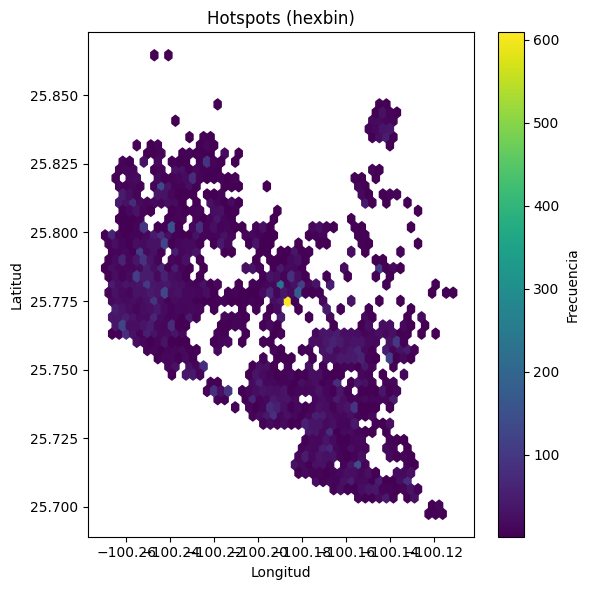

In [ ]:
# Mapa de densidad simple con hist2d (sin mapas base)
plt.figure(figsize=(6, 6))
plt.hist2d(geotest_coordinates["LONGITUD"], geotest_coordinates["LATITUD"], bins=60)
plt.title("Densidad espacial (hist2d)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(label="Frecuencia")
plt.tight_layout()
plt.show()

# Hexbin (suave y útil para hotspots)
plt.figure(figsize=(6, 6))
plt.hexbin(geotest_coordinates["LONGITUD"], geotest_coordinates["LATITUD"], gridsize=50,
           mincnt=1)
plt.title("Hotspots (hexbin)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(label="Frecuencia")
plt.tight_layout()
plt.show()

**Observaciones**

**Plot 1: Histograma 2D – “Densidad espacial (hist2d)”**


- Hotspot principal en Lat ~25.78, Lon ~−100.24, con más de 300 incidentes en una sola celda.

- Celdas circundantes con densidad media-alta (100–200).

- La densidad cae rápidamente fuera de este clúster.

**Plot 2: Mapa Hexbin – “Hotspots (hexbin)”**

- Confirma el mismo hotspot principal (25.78 / −100.24).

- Destaca clústeres secundarios al sur (25.74–25.72, −100.18 a −100.14).

- Se observan hexágonos dispersos de menor intensidad en toda el área.

- El método hexbin revela mejor patrones lineales o corredores urbanos que el binning cuadrado.

Duplicados (DT_15, lat, lon): 58


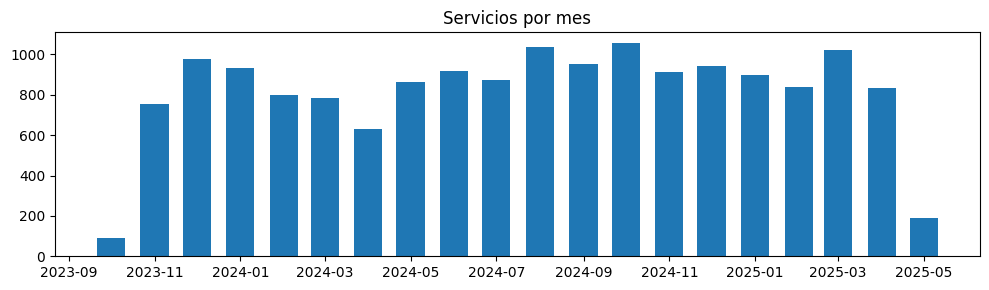

In [ ]:
dups = geotest_coordinates.duplicated(subset=["DT_15", "LATITUD", "LONGITUD"],
                                      keep=False)
print("Duplicados (DT_15, lat, lon):", dups.sum())

# Visual rápido de cargas por mes (para revisar picos anómalos)
monthly = geotest_coordinates.set_index("DT_15").resample("MS").size()
plt.figure(figsize=(10, 3))
plt.bar(monthly.index, monthly.values, width=20)  # barra ancha tipo “mes”
plt.title("Servicios por mes")
plt.tight_layout()
plt.show()

**Observaciones**

1. Pico de actividad (ene–mar 2024):

- Enero 2024: ~510 despachos

- Febrero 2024: ~600 despachos (máximo absoluto)

- Marzo 2024: ~580 despachos: Este trimestre representa la mayor demanda de servicios de emergencia.

2. Meseta de alto volumen (dic 2023 – may 2024):

- Volúmenes sostenidos entre 440 y 600 despachos mensuales.

- Ventana de seis meses con alta demanda:

- Dic 2023 (~460)

- Ene–Mar (pico)

- Abr–May (~430–440)

3. Caída abrupta (desde jun 2024):

- Jun 2024: descenso a ~380

- Desde jul 2024: la actividad colapsa a cifras bajas:

- Jul 2024: ~60

- Ago–Dic 2024: estabilización en 100–150 llamadas mensuales

In [ ]:
df = geotest_coordinates.copy()

# Redondea a 4 decimales ≈ 11 m lat / ~10 m lon en Apodaca
DEC = 4
df["LAT_r"] = df["LATITUD"].round(DEC)
df["LON_r"] = df["LONGITUD"].round(DEC)
df["CELL"] = df["LAT_r"].astype(str) + "," + df["LON_r"].astype(str)  # id de celda

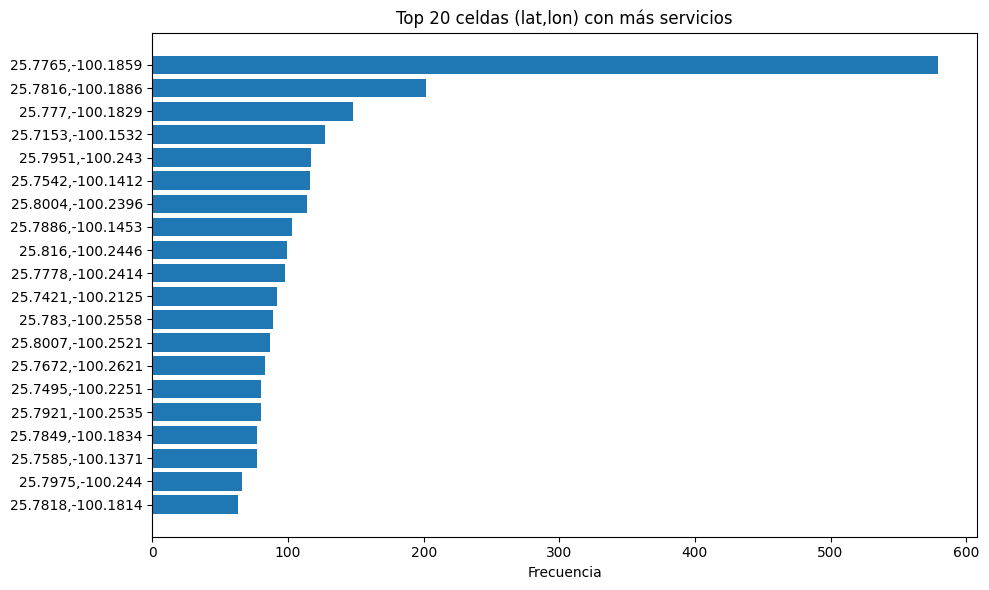

Celdas únicas totales: 6721


In [ ]:
topN = 20
cell_counts = df["CELL"].value_counts()
top_cells = cell_counts.head(topN)

plt.figure(figsize=(10, 6))
plt.barh(top_cells.index[::-1], top_cells.values[::-1])
plt.title(f"Top {topN} celdas (lat,lon) con más servicios")
plt.xlabel("Frecuencia")
plt.tight_layout()
plt.show()

print("Celdas únicas totales:", df["CELL"].nunique())

**Observaciones**
Top ubicaciones más frecuentes:
1. Centro de Apodaca
2. Municipio de Apodaca
3. Pueblo Nuevo
4. Metroplex

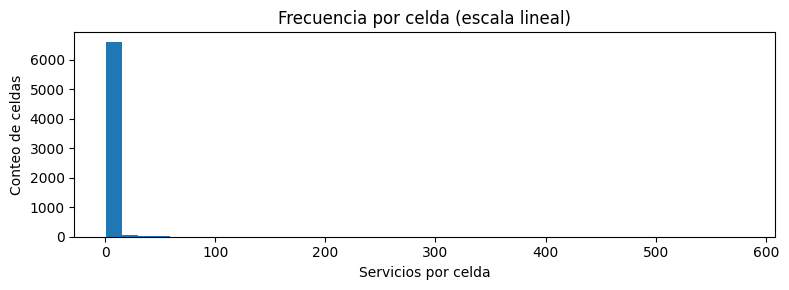

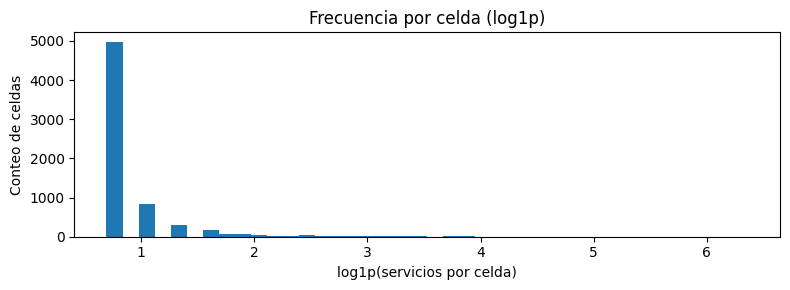

In [ ]:
freq = cell_counts.values  # frecuencia por celda
plt.figure(figsize=(8, 3))
plt.hist(freq, bins=40)
plt.title("Frecuencia por celda (escala lineal)")
plt.xlabel("Servicios por celda")
plt.ylabel("Conteo de celdas")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.hist(np.log1p(freq), bins=40)
plt.title("Frecuencia por celda (log1p)")
plt.xlabel("log1p(servicios por celda)")
plt.ylabel("Conteo de celdas")
plt.tight_layout()
plt.show()

**Observaciones**

**Plot 1: Frecuencia por celda (escala lineal)**

- Gran concentración en celdas de baja frecuencia:

- La mayoría de las celdas (más de 600) registran solo 1–5 servicios.

- Caída rápida a medida que aumenta la frecuencia.

- Muy pocas celdas superan los 50+ servicios.

- Solo un pequeño número de outliers extremos alcanza entre 100–300 servicios.

- Distribución altamente sesgada.

**Plot 2: Frecuencia por celda (log1p)**


- Se utiliza log1p(x) para expandir la cola larga de los datos, el cual permite analizar con mayor claridad la distribución sesgada hacia la derecha.

- La frecuencia de despachos por celda sigue un patrón similar a una distribución tipo ley de potencias:

- Pocas zonas concentran la mayoría de llamadas.

- La mayoría de las zonas permanecen casi inactivas.

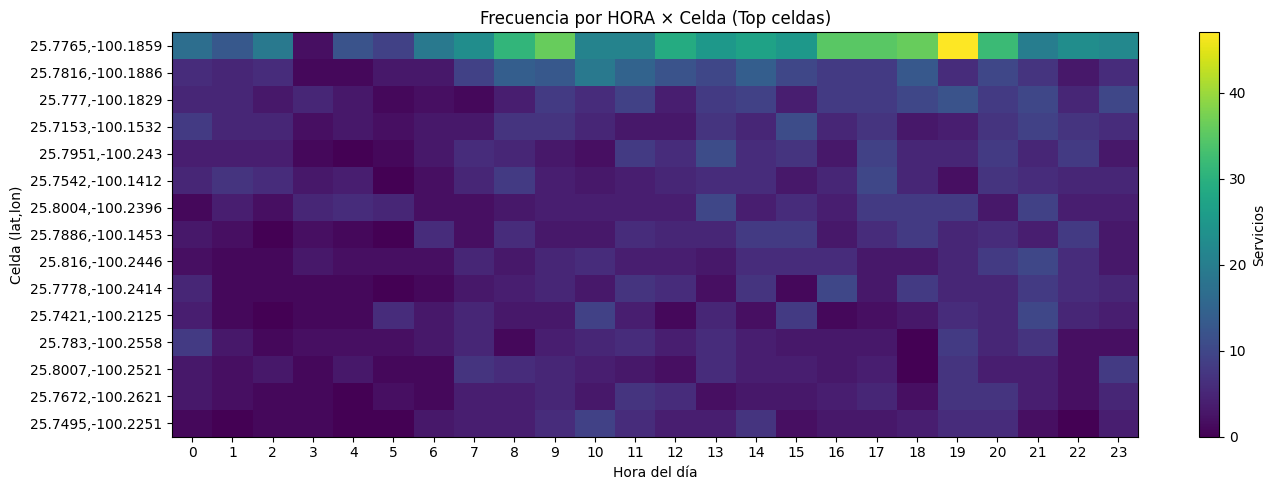

In [ ]:
# Tabla hora (0..23) × celda (Top K)
K = 15
cells_to_show = cell_counts.head(K).index
hour_cell = (df.groupby(["HORA_H", "CELL"]).size()
             .unstack(fill_value=0)
             .reindex(index=range(24), fill_value=0))[cells_to_show]

plt.figure(figsize=(14, 5))
im = plt.imshow(hour_cell.values.T, aspect="auto", origin="upper")
plt.title("Frecuencia por HORA × Celda (Top celdas)")
plt.xlabel("Hora del día")
plt.ylabel("Celda (lat,lon)")
plt.xticks(range(24), range(24))
plt.yticks(range(K), cells_to_show)
plt.colorbar(im, label="Servicios")
plt.tight_layout()
plt.show()

**Observaciones**
1. Hotspot dominante (25.7801, -100.2504):

- Destaca en casi todas las horas del día.

- Mayor frecuencia alrededor de las 19:00 (7 PM), con más de 30 servicios.

- Otras horas de alta actividad: 10:00, 13:00 y 20:00.

- Representa una zona hiperactiva con demanda bien distribuida a lo largo del día.

2. Celdas constantemente activas:

- Coordenadas: (25.7452, -100.1641) y (25.7876, -100.2524).

- Muestran alta actividad de la mañana al inicio de la tarde (08:00–14:00).

- Contribuyen de manera significativa a la demanda del mediodía.

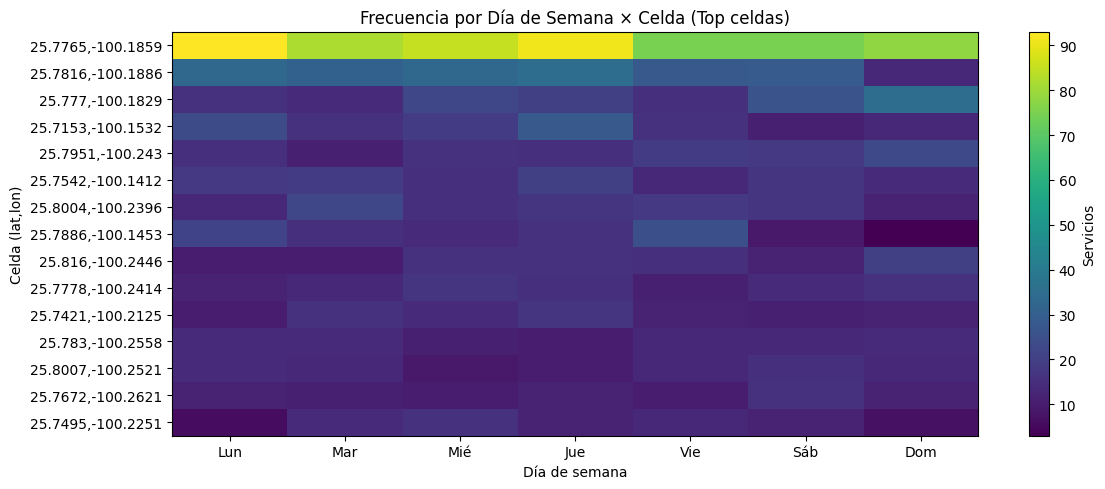

In [ ]:
weekday_order = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
wk_cell = (df.groupby(["WEEKDAY_NAME", "CELL"]).size()
           .unstack(fill_value=0)
           .reindex(index=weekday_order))[cells_to_show]

plt.figure(figsize=(12, 5))
im = plt.imshow(wk_cell.values.T, aspect="auto", origin="upper")
plt.title("Frecuencia por Día de Semana × Celda (Top celdas)")
plt.xlabel("Día de semana")
plt.ylabel("Celda (lat,lon)")
plt.xticks(range(7), weekday_order)
plt.yticks(range(K), cells_to_show)
plt.colorbar(im, label="Servicios")
plt.tight_layout()
plt.show()

**Observaciones**
1. Celda principal (25.7801, -100.2504):

- Mayor volumen de despachos el domingo (~60 servicios).

- Alta actividad durante toda la semana, especialmente en:

  Martes

  Lunes, miércoles y sábado

- Este punto mantiene niveles elevados de manera constante, con un pico los fines de semana.

2. Celdas de alta consistencia:

- Coordenadas: (25.7452, -100.1641) y (25.7876, -100.2524).

- Muestran un volumen estable de lunes a viernes, con ligera caída sábado y domingo.

- Patrón sugiere que corresponden a zonas laborales o escolares con mayor demanda entre semana.

3. Zonas con picos de fin de semana:

- Coordenadas destacadas:

  (25.7817, -100.1888)

  (25.7698, -100.2471)

  (25.7805, -100.2408)

  Presentan aumentos significativos en sábado y domingo.

  Probablemente vinculados a zonas residenciales o de vida nocturna.

4. Patrones de picos los martes:

- Varias celdas intermedias muestran incrementos notables los martes, por ejemplo:

  (25.7125, -100.1546)

  (25.7433, -100.1933)

- Posible relación con factores de riesgo específicos entre semana, como consultorios, mercados o actividades programadas.

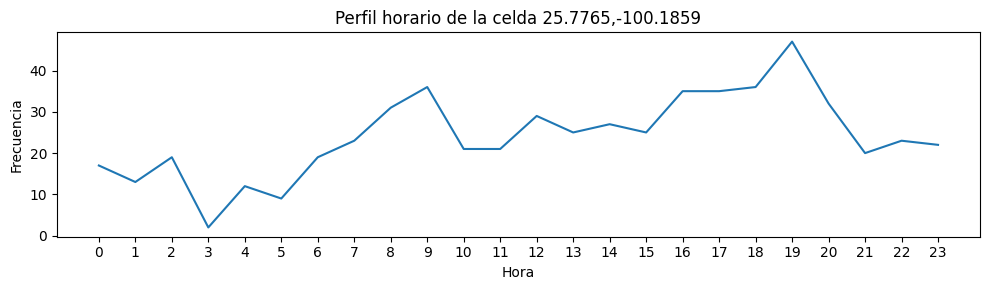

In [ ]:
def plot_cell_hour_profile(cell_id):
    s = df.loc[df["CELL"] == cell_id, "HORA_H"].value_counts().sort_index()
    s = s.reindex(range(24), fill_value=0)
    plt.figure(figsize=(10, 3))
    plt.plot(s.index, s.values)
    plt.title(f"Perfil horario de la celda {cell_id}")
    plt.xlabel("Hora")
    plt.ylabel("Frecuencia")
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

# Ejemplo: primera celda del Top
plot_cell_hour_profile(top_cells.index[0])

**Observaciones**

* Pico máximo a las 19:00 hrs, con más de 30 servicios.

* Alta actividad también entre 9:00 y 20:00 hrs, marcando un patrón continuo de demanda en el día.

* Menor actividad en la madrugada (05:00 hrs, mínimo).

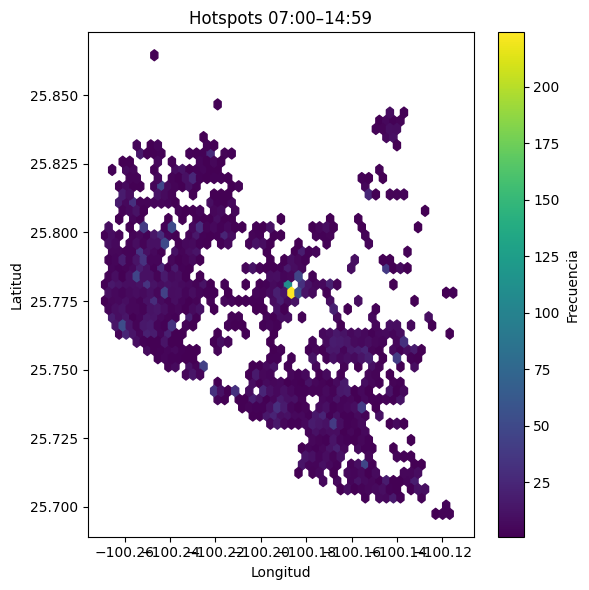

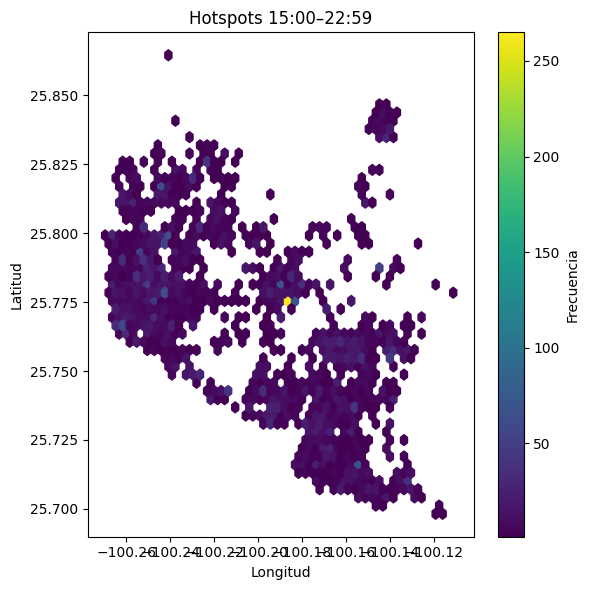

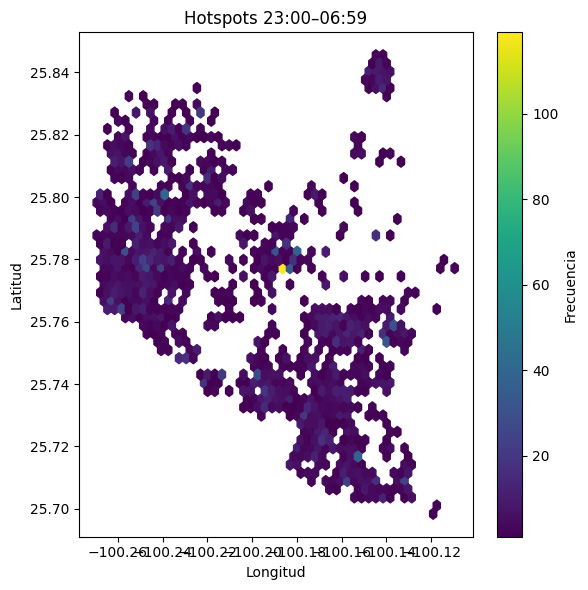

In [ ]:
def hexbin_por_franja(mask, titulo, gridsize=50):
    sub = df[mask]
    plt.figure(figsize=(6, 6))
    plt.hexbin(sub["LONGITUD"], sub["LATITUD"], gridsize=gridsize, mincnt=1)
    plt.title(titulo)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.colorbar(label="Frecuencia")
    plt.tight_layout()
    plt.show()

hexbin_por_franja((df["HORA_H"] >= 7) & (df["HORA_H"] < 15), "Hotspots 07:00–14:59")
hexbin_por_franja((df["HORA_H"] >= 15) & (df["HORA_H"] < 23), "Hotspots 15:00–22:59")
hexbin_por_franja((df["HORA_H"] < 7) | (df["HORA_H"] >= 23), "Hotspots 23:00–06:59")

**Observaciones**


**Temporal**

- Pico de servicios: Ocurre entre las 14:00 y 21:00 horas, siendo las 20:00 la hora con mayor número de servicios.
- Variación semanal: La distribución por días de la semana es relativamente homogénea, aunque se observa un ligero repunte los sábados.
- Tendencia mensual: Hubo un máximo de actividad entre enero y abril de 2024, seguido de una baja significativa a partir de julio 2024.

---

**Espacial**

- Concentración geográfica: La mayoría de los servicios se concentran en la zona entre latitudes 25.74 a 25.78 y longitudes -100.26 a -100.14.
- Alta concentración (Top celdas):
  - Celda más activa: (25.7801, -100.2504).
  - Las 20 celdas más activas representan una proporción desbalanceada de los servicios, con una larga cola de celdas con muy baja actividad.

---

**Espacio vs Tiempo**

- Top celdas tienen picos en las tardes (14:00–20:00), especialmente la celda principal (25.7801, -100.2504) con su pico a las 19:00.
- Hotspots por franja horaria:
  - 07:00–14:59: Se observa dispersión moderada.
  - 15:00–22:59: Mayor concentración, sobre todo en la zona central.
  - 23:00–06:59: Baja actividad, pero con presencia persistente en algunas zonas específicas.

---

**Ubicación descriptiva**

- Ubicaciones más frecuentes:
  - CENTRO DE APODACA
  - MUNICIPIO DE APODACA
- Distribución de frecuencias sigue una curva fuertemente sesgada, con muchas ubicaciones de baja recurrencia.

---

Conclusión

- Existe una alta concentración espacial y horaria en los servicios, lo que permite optimizar operaciones si se focalizan esfuerzos en los puntos calientes vespertinos y en las zonas más activas de Apodaca.

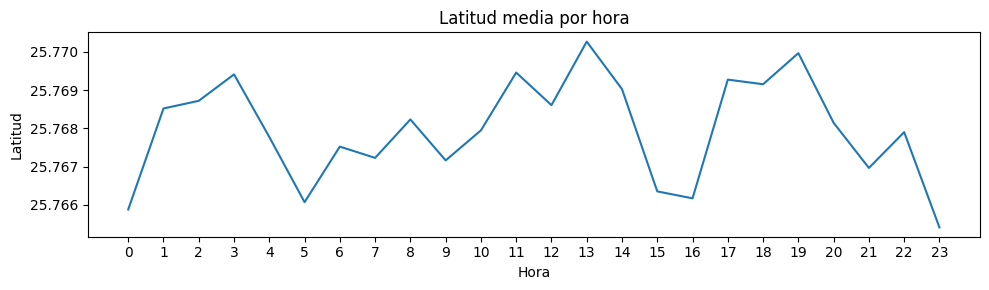

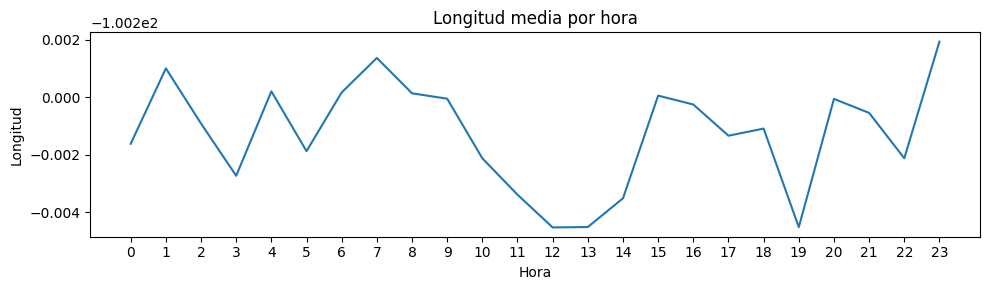

In [ ]:
cent = df.groupby("HORA_H")[["LATITUD", "LONGITUD"]].mean()

plt.figure(figsize=(10, 3))
plt.plot(cent.index, cent["LATITUD"].values)
plt.title("Latitud media por hora")
plt.xlabel("Hora")
plt.ylabel("Latitud")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(cent.index, cent["LONGITUD"].values)
plt.title("Longitud media por hora")
plt.xlabel("Hora")
plt.ylabel("Longitud")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

**Observaciones**
- Cargas horarias concentradas entre 09:00 y 21:00 horas.
- Fuerte polarización espacial, con unas pocas celdas concentrando la mayoría de los servicios.
- Disminución marcada de servicios en la segunda mitad del periodo (posible cambio operativo o estacionalidad).

## **Conclusiones del EDA:**
- Se confirmaron valores faltantes iniciales, que fueron eliminados; no quedaron patrones de ausencia relevantes.
- Se identificaron outliers en coordenadas y se aplicó filtrado para depurarlos.
- La variable `UBICACION` presenta alta cardinalidad, aunque con concentración en ciertos puntos.
- Existen distribuciones sesgadas en algunas variables numéricas (ej. minutos desde medianoche).
- Se detectaron tendencias temporales con picos en ciertos días y horarios.
- Se observó un desbalance espacial: pocas celdas concentran gran parte de los servicios.

# CLUSTERING

## Se dividen las coordenadas en un número de clusters definidos "n_clusters".
En este caso se utiliza n_cluster = 4 ya que se cuentan con 4 ambulancias activas las 24 horas del día.

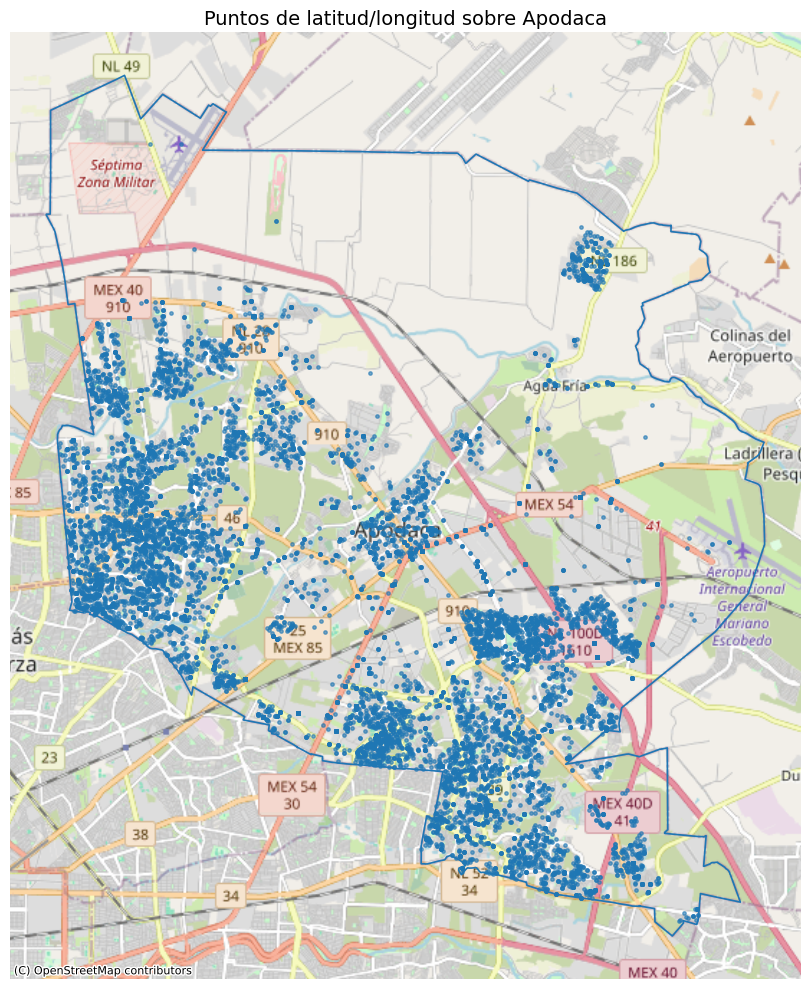

In [ ]:
# !pip install osmnx geopandas contextily shapely

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
from shapely.geometry import Point

# --- 1) DataFrame -> GeoDataFrame en lat/lon ---
df = geotest_coordinates.dropna(subset=['LATITUD', 'LONGITUD']).copy()
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']),
    crs='EPSG:4326'  # WGS84
)

# --- 2) Polígono de Apodaca y (opcional) filtrado ---
apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")

# (Opcional) Si quisieras asegurar solo puntos dentro del municipio:
# gdf = gdf[gdf.within(apodaca.loc[0, 'geometry'])]

# --- 3) Convertir todo a Web Mercator (metros) para basemap ---
gdf_web = gdf.to_crs(epsg=3857)
apodaca_web = apodaca.to_crs(epsg=3857)

# --- 4) Graficar: borde municipal + puntos + basemap ---
fig, ax = plt.subplots(figsize=(10, 10))
apodaca_web.boundary.plot(ax=ax, linewidth=1.2)  # límite municipal
gdf_web.plot(ax=ax, markersize=6, alpha=0.6)  # scatter sencillo

# Basemap OSM
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Puntos de latitud/longitud sobre Apodaca", fontsize=14)
ax.set_aspect('equal', adjustable='box')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
# INPUT Número de clusters. Se utilizan 4 ya que hay 4 ambulancias en todo momento a disposición.
n_clusters = 4

In [ ]:
# Se genera la función para divsión de coordenadas por proximidad
def divide_samples_by_proximity(df, n_clusters):
    """
    Divides the samples into n clusters based on
    their geographic proximity.

    Parameters:
    - df: DataFrame containing the samples with
    'Latitud' and 'Longitud' columns.
    - n_clusters: The number of divisions
    (clusters) to create.

    Returns:
    - A list of DataFrames, each containing the samples
    for one cluster.
    """
    # Se extrae latitud y longitud
    coords = df[['LATITUD', 'LONGITUD']]

    # Se utiliza clustering de KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42). \
        fit(coords)
    df['Cluster'] = kmeans.labels_

    # Se divide el dataframe en el número definido de clusters y se almacenan en una lista
    cluster_dfs = [df[df['Cluster'] == i].drop('Cluster', axis=1) \
                   for i in range(n_clusters)]

    return cluster_dfs

In [ ]:
geotest_df_clusters = divide_samples_by_proximity(geotest_coordinates, n_clusters)

# Impresion de número de muestras por cluster
for i, cluster_df in enumerate(geotest_df_clusters):
    print(f"Cluster {i+1} has {len(cluster_df)} samples.")

Cluster 1 has 4140 samples.
Cluster 2 has 3098 samples.
Cluster 3 has 6046 samples.
Cluster 4 has 3020 samples.


## Gráfica de coordenadas divididas por Cluster

In [ ]:
# !pip install osmnx geopandas contextily shapely

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
from shapely.geometry import Point


def plot_clusters_on_apodaca(geotest_df_clusters, colors=None, markersize=8, edgecolor='k',
                             alpha=0.6):
    """
    Dibuja los puntos de cada clúster sobre el mapa de Apodaca (OSM).
    - geotest_df_clusters: list[pd.DataFrame] con columnas ['LATITUD','LONGITUD']
    - colors: lista de colores (opcional). Si es None, usa la paleta tab10 cíclica.
    """
    # 1) Polígono de Apodaca (EPSG:4326 -> 3857)
    apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")
    apodaca_web = apodaca.to_crs(epsg=3857)

    # 2) Preparar paleta
    if colors is None:
        cmap = plt.get_cmap('tab10')

        def get_color(i):
            return cmap(i % 10)
    else:
        def get_color(i):
            return colors[i % len(colors)]

    # 3) Figura base
    fig, ax = plt.subplots(figsize=(10, 10))
    apodaca_web.boundary.plot(ax=ax, linewidth=1.2, color='black', label='Límite Apodaca')

    handles = []
    labels = []

    # 4) Dibujar cada clúster
    for i, cdf in enumerate(geotest_df_clusters, start=1):
        df = cdf.dropna(subset=['LATITUD', 'LONGITUD']).copy()
        if df.empty:
            continue

        # DataFrame -> GeoDataFrame en WGS84 y luego a Web Mercator
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df['LONGITUD'], df['LATITUD']),
            crs='EPSG:4326'
        ).to_crs(epsg=3857)

        col = get_color(i - 1)
        # Usa ax.scatter para controlar mejor los estilos
        x = gdf.geometry.x.values
        y = gdf.geometry.y.values
        sc = ax.scatter(x, y, s=markersize, c=[col], alpha=alpha,
                        edgecolors=edgecolor, linewidths=0.4, label=f'Cluster {i}')
        handles.append(sc)
        labels.append(f'Cluster {i}')

    # 5) Basemap OSM
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # 6) Estética
    ax.set_title('Distribución geográfica de los Clústeres – Apodaca', fontsize=14)
    ax.set_aspect('equal', adjustable='box')
    ax.set_axis_off()

    # Leyenda sin duplicados
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()

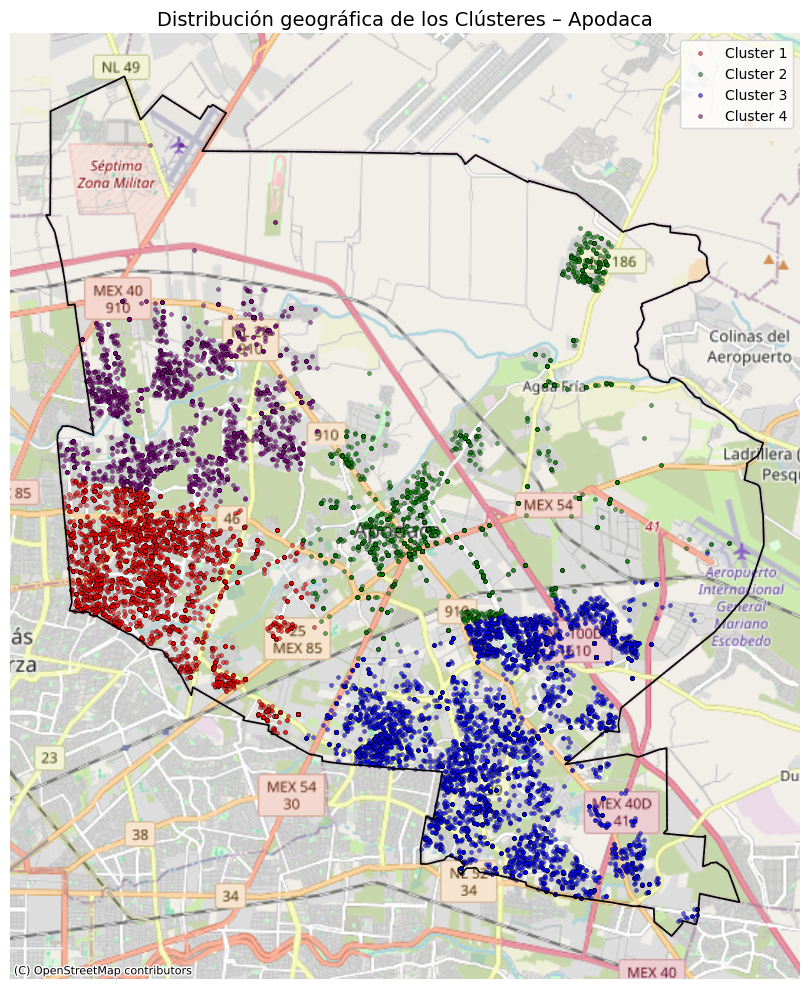

In [ ]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'black',
          'gray']

plot_clusters_on_apodaca(
    geotest_df_clusters,
    colors=colors,  # o deja None para usar tab10
    markersize=8,
    edgecolor='k',
    alpha=0.6
)

## Estudio descriptivo de los Clusters

## Se muestran los clusters como listas:

In [ ]:
for i, cluster_df in enumerate(geotest_df_clusters):
    print(f"Cluster {i+1}:")
    print(cluster_df.head())
    print(f"Total samples in Cluster {i+1}: {len(cluster_df)}\n")

Cluster 1:
         FECHA      HORA                                          UBICACION  \
1   2023-10-27  08:09:00  MANANTIAL 507 LAGO       COLONIA    EL MANANTI...   
9   2023-10-27  11:39:00   JAPON 203   COLONIA  NUEVO AMANECER 2 APODACA NL   
11  2023-10-27  14:15:00  BOLIVIA 106       COLONIA    NUEVO AMANECER 1 ...   
12  2023-10-27  14:52:00  CTO CLIO ALAYA  CTO CLIO 225       COLONIA  PR...   
13  2023-10-27  15:22:00  ALTAGRACIA MERCADO 607      COLONIA  MUJERES I...   

                                 COORDENADAS    LATITUD    LONGITUD  \
1    {'lat': 25.783571, 'lon': -100.2646878}  25.783571 -100.264688   
9   {'lat': 25.7707874, 'lon': -100.2430936}  25.770787 -100.243094   
11  {'lat': 25.7802725, 'lon': -100.2485886}  25.780272 -100.248589   
12  {'lat': 25.7760832, 'lon': -100.2142972}  25.776083 -100.214297   
13  {'lat': 25.7679355, 'lon': -100.2640543}  25.767936 -100.264054   

     FECHA_dt         HORA_td                  DT               DT_15 HORA_15  \
1  202

### Se genera una descripción por cada cluster

In [ ]:
for i, cluster_df in enumerate(geotest_df_clusters):
    print(f"Summary statistics for Cluster {i+1}:")
    print(cluster_df.info())
    print(cluster_df.describe())
    print("\n")

Summary statistics for Cluster 1:
<class 'pandas.core.frame.DataFrame'>
Index: 4140 entries, 1 to 16297
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   FECHA                 4140 non-null   object         
 1   HORA                  4140 non-null   object         
 2   UBICACION             4140 non-null   object         
 3   COORDENADAS           4140 non-null   object         
 4   LATITUD               4140 non-null   float64        
 5   LONGITUD              4140 non-null   float64        
 6   FECHA_dt              4140 non-null   datetime64[ns] 
 7   HORA_td               4140 non-null   timedelta64[ns]
 8   DT                    4140 non-null   datetime64[ns] 
 9   DT_15                 4140 non-null   datetime64[ns] 
 10  HORA_15               4140 non-null   category       
 11  HORA_H                4140 non-null   int32          
 12  WEEKDAY               4140 non-n

#Feature Engineering

## Feature Engineering: `engineer_features_v2`

## 1. Transformación de fechas y horas
- **`FECHA_dt` y `HORA_td`**: convierten las columnas `FECHA` y `HORA` a objetos `datetime` y `timedelta`. Esto se realiza debido a que los modelos no interpretan fechas crudas; es necesario convertirlas en representaciones numéricas.
- **`DT`**: une fecha y hora en un único timestamp para facilitar operaciones de series de tiempo.

---

## 2. Variables temporales derivadas
- **`MIN_DESDE_MEDIANOCHE`**: minutos transcurridos desde la medianoche.  
- **`HORA_H`**: hora del día (0–23).  
- **`HORA_15`**: discretización en intervalos de 15 minutos.  
- **`WEEKDAY` y `WEEKDAY_NAME`**: día de la semana como número y nombre.  

Estas variables permiten capturar **patrones horarios y semanales** en la ocurrencia de incidentes. Por ejemplo, algunos servicios se concentran en la tarde o ciertos días de la semana.

---

## 3. Codificación cíclica del tiempo
- **`time_sin` y `time_cos`**: representan la hora del día en un círculo trigonométrico.  

El tiempo es una variable **cíclica** (después de las 23:59 sigue 00:00).  
Codificarlo con seno/coseno evita que el modelo interprete 23 y 0 como valores lejanos, manteniendo la continuidad.

---

## 4. Agrupación en turnos
- **`SHIFT4`**: divide las 24 horas en 4 categorías:
  - `NIGHT` (0–5), `MORNING` (6–11), `AFTERNOON` (12–17), `EVENING` (18–23).  

Esto simplifica la variable temporal en **turnos operativos**.
---

## 5. Codificación de variables categóricas
- **Ubicación (`UBICACION`)**:
  - `freq encoding`: Ideal para variables de **alta cardinalidad**, cada valor se reemplaza por la frecuencia relativa de su aparición.
- **Variables de baja cardinalidad (`HORA_15`, `WEEKDAY_NAME`, `SHIFT4`)**:
  - Se aplican **one-hot encoding** para preservar información categórica sin orden artificial.

---

## 6. Eliminación de redundancias
- Elimina columnas crudas o textuales (`FECHA`, `HORA`, `COORDENADAS`, etc.) después de haber generado las variables derivadas.
- Mantiene únicamente **variables numéricas y codificadas**.
- Mediante este proceso se reduce dimensionalidad, evita colinealidad y asegura que el dataset final sea adecuado para algoritmos de ML.

---

## 7. Salida
La función devuelve:
1. **`dfc`**: DataFrame con las variables ya transformadas y listas para modelar.  
2. **`meta`**: información adicional con:
   - columnas eliminadas y conservadas,  
   - encoders aplicados,  
   - notas sobre las transformaciones.  


In [ ]:
def engineer_features_v2(
    df: pd.DataFrame,
    *,
    onehot_small_cats=True,
    encode_ubicacion="freq",  # {"none", "freq"}
    add_shift_bins=True,  # morning/afternoon/evening/night
    drop_redundant_raw=True,  # drop raw datetime/timedelta/text columns after deriving features
    keep_cols_extra=None  # list of extra cols to keep verbatim (if they exist)
):
    """
    Feature engineering for emergency incident records with robust handling of already-engineered columns.

    Parameters
    ----------
    df : DataFrame
        Input cluster DataFrame (may contain FECHA/HORA raw or engineered time columns).
    onehot_small_cats : bool
        One-hot encode small-cardinality categorical variables (HORA_15, WEEKDAY_NAME).
    encode_ubicacion : {"none","freq"}
        Encoding for UBICACION. "freq" maps each value to its relative frequency.
    add_shift_bins : bool
        Adds a coarse time-of-day bin: NIGHT [0-5], MORNING [6-11], AFTERNOON [12-17], EVENING [18-23].
    drop_redundant_raw : bool
        Drops raw datetime/timedelta/object columns that are superseded by engineered features.
    keep_cols_extra : list[str] | None
        Extra columns to preserve verbatim (e.g., IDs).

    Returns
    -------
    X : DataFrame
        Engineered feature matrix (numeric + any one-hot columns).
    meta : dict
        Metadata: columns_kept, columns_dropped, encoders (e.g., frequency map for UBICACION), notes.
    """
    dfc = df.copy()
    notes = []
    cols_before = set(dfc.columns)
    encoders = {}

    # ---------- 1) Ensure datetime/time bases exist ----------
    # FECHA_dt
    if "FECHA_dt" not in dfc.columns and "FECHA" in dfc.columns:
        dfc["FECHA_dt"] = pd.to_datetime(dfc["FECHA"], format="%Y-%m-%d", errors="coerce")
        notes.append("Built FECHA_dt from FECHA.")
    # HORA_td
    if "HORA_td" not in dfc.columns and "HORA" in dfc.columns:
        # Accept HH:MM or HH:MM:SS
        dt_hora = pd.to_datetime(dfc["HORA"], errors="coerce")
        dfc["HORA_td"] = (dt_hora.dt.hour.fillna(0).astype(int) * 3600
                          + dt_hora.dt.minute.fillna(0).astype(int) * 60
                          + dt_hora.dt.second.fillna(0).astype(int)).astype("timedelta64[s]")
        notes.append("Built HORA_td from HORA.")
    # DT (full timestamp)
    if "DT" not in dfc.columns:
        if ("FECHA_dt" in dfc.columns) and ("HORA_td" in dfc.columns):
            dfc["DT"] = dfc["FECHA_dt"] + dfc["HORA_td"]
            notes.append("Built DT from FECHA_dt + HORA_td.")

    # ---------- 2) Minute-of-day + hour ----------
    if "MIN_DESDE_MEDIANOCHE" not in dfc.columns:
        if "HORA_td" in dfc.columns:
            mins = (dfc["HORA_td"].dt.total_seconds() / 60.0).round().astype("Int64")
            dfc["MIN_DESDE_MEDIANOCHE"] = mins.clip(lower=0, upper=23 * 60 + 59).astype(
                "float")
            notes.append("Built MIN_DESDE_MEDIANOCHE from HORA_td.")
        elif "HORA" in dfc.columns:
            dt_hora = pd.to_datetime(dfc["HORA"], errors="coerce")
            mins = (dt_hora.dt.hour * 60 + dt_hora.dt.minute).astype("Int64")
            dfc["MIN_DESDE_MEDIANOCHE"] = mins.astype("float")
            notes.append("Built MIN_DESDE_MEDIANOCHE from HORA.")
    if "HORA_H" not in dfc.columns and "MIN_DESDE_MEDIANOCHE" in dfc.columns:
        dfc["HORA_H"] = (dfc["MIN_DESDE_MEDIANOCHE"] // 60).astype(int)
        notes.append("Built HORA_H from MIN_DESDE_MEDIANOCHE.")

    # ---------- 3) 15-minute bin ----------
    if "HORA_15" not in dfc.columns and "MIN_DESDE_MEDIANOCHE" in dfc.columns:
        q = (dfc["MIN_DESDE_MEDIANOCHE"] // 15).astype("Int64")
        # Human-readable label HH:MM for the bin start
        label = (q * 15).astype(float)
        label = label.fillna(0)
        hh = (label // 60).astype(int).clip(0, 23)
        mm = (label % 60).astype(int).clip(0, 59)
        dfc["HORA_15"] = pd.Categorical(hh.astype(str).str.zfill(2) + ":" + mm.astype(str).str.zfill(2))
        notes.append("Created 15-minute categorical bin HORA_15.")

    # ---------- 4) Weekday ----------
    if "WEEKDAY" not in dfc.columns and "FECHA_dt" in dfc.columns:
        dfc["WEEKDAY"] = dfc["FECHA_dt"].dt.dayofweek  # Mon=0..Sun=6
        notes.append("Built WEEKDAY from FECHA_dt.")
    if "WEEKDAY_NAME" not in dfc.columns and "WEEKDAY" in dfc.columns:
        wkmap = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
        dfc["WEEKDAY_NAME"] = dfc["WEEKDAY"].map(wkmap).astype("object")
        notes.append("Built WEEKDAY_NAME from WEEKDAY.")

    # ---------- 5) Cyclic encodings for time ----------
    if "MIN_DESDE_MEDIANOCHE" in dfc.columns:
        # Normalize to [0,1) of a day
        frac_day = dfc["MIN_DESDE_MEDIANOCHE"] / (24 * 60.0)
        dfc["time_sin"] = np.sin(2 * np.pi * frac_day)
        dfc["time_cos"] = np.cos(2 * np.pi * frac_day)
        notes.append("Added cyclic time features (time_sin, time_cos) from MIN_DESDE_MEDIANOCHE.")

    # ---------- 6) Optional coarse shift bins ----------
    if add_shift_bins and "HORA_H" in dfc.columns:
        # 0-5 night, 6-11 morning, 12-17 afternoon, 18-23 evening
        def _shift(h):
            if 0 <= h <= 5:
                return "NIGHT"
            if 6 <= h <= 11:
                return "MORNING"
            if 12 <= h <= 17:
                return "AFTERNOON"
            return "EVENING"

        dfc["SHIFT4"] = pd.Categorical(dfc["HORA_H"].apply(_shift))
        notes.append("Added SHIFT4 time-of-day bin.")

    # ---------- 7) Encoding ----------
    # UBICACION: high-cardinality → frequency encoding by default
    if "UBICACION" in dfc.columns and encode_ubicacion == "freq":
        freqs = dfc["UBICACION"].value_counts(dropna=False)
        total = len(dfc)
        freq_map = (freqs / total).to_dict()
        dfc["UBICACION_FREQ"] = dfc["UBICACION"].map(freq_map).astype(float)
        encoders["UBICACION_FREQ_map"] = freq_map
        notes.append("Encoded UBICACION with frequency encoding -> UBICACION_FREQ.")

    # One-hot for small-cardinality categories
    cat_small = []
    if "HORA_15" in dfc.columns:
        cat_small.append("HORA_15")
    if "WEEKDAY_NAME" in dfc.columns:
        cat_small.append("WEEKDAY_NAME")
    if "SHIFT4" in dfc.columns:
        cat_small.append("SHIFT4")

    if onehot_small_cats and cat_small:
        dfc = pd.get_dummies(dfc, columns=cat_small, drop_first=False, dtype=int)
        notes.append(f"One-hot encoded {cat_small}.")

    # ---------- 8) Drop redundancy / non-numeric ----------
    drop_candidates = []
    if drop_redundant_raw:
        # Raw or superseded columns
        drop_candidates += [
            "FECHA", "HORA", "COORDENADAS",
            "FECHA_dt", "HORA_td", "DT", "DT_15",
            "WEEKDAY_NAME"  # was one-hot encoded if enabled
        ]
        # Keep HORA_15 only if not one-hot’d
        if onehot_small_cats:
            drop_candidates.append("HORA_15")
        # Keep UBICACION if not needed
        if encode_ubicacion == "freq":
            drop_candidates.append("UBICACION")

    # Don’t drop targets or explicitly kept columns
    protect = {"LATITUD", "LONGITUD"}
    if keep_cols_extra:
        protect |= set(keep_cols_extra)
    to_drop = [c for c in drop_candidates if c in dfc.columns and c not in protect]
    dfc.drop(columns=to_drop, inplace=True, errors="ignore")

    # Keep only numeric after encoding (plus protected)
    non_numeric = [c for c in dfc.columns if
                   (not np.issubdtype(dfc[c].dtype, np.number)) and (c not in protect)]
    if non_numeric:
        dfc.drop(columns=non_numeric, inplace=True, errors="ignore")

    # ---------- 9) Output ----------
    cols_after = list(dfc.columns)
    meta = {
        "columns_kept": cols_after,
        "columns_dropped": [c for c in cols_before if c not in cols_after],
        "encoders": encoders,
        "notes": notes,
    }
    return dfc, meta

## Feature Engineering y División de Datos: `feature_division_v2`

## 1. Ingeniería de características
Cada DataFrame de la lista `clusters` pasa primero por la función [`engineer_features_v2`](#), que:
- Convierte variables de fecha, hora y ubicación en características numéricas y categóricas.  
- Aplica codificación one-hot a variables de baja cardinalidad.  
- Aplica **frequency encoding** a `UBICACION`.  
- Elimina columnas redundantes o textuales.  

---

## 2. Separación de variables predictoras (X) y objetivos (Y)
- **Objetivo (Y)**: coordenadas `LATITUD` y `LONGITUD`.  
- **Predictoras (X)**: todas las demás variables transformadas.  

---

## 3. División de datos en conjuntos
Se utiliza `train_test_split` de **scikit-learn** para dividir los datos de cada cluster:

- 70% → **Entrenamiento** (`X_train`, `Y_train`).  
- 15% → **Validación** (`X_val`, `Y_val`).  
- 15% → **Prueba** (`X_test`, `Y_test`).  

---

## 4. Escalamiento de los objetivos
Se aplica `MinMaxScaler` a `LATITUD` y `LONGITUD` para la su normalización, el cual:
- Ajusta los valores al rango [0,1].  
- Guarda el objeto `scaler` para poder transformar/invertir coordenadas después.  

---

## 5. Estructura de salida
Por cada cluster se genera un diccionario con:
- `meta`: información sobre las transformaciones aplicadas (proveniente de `engineer_features_v2`).  
- `X_train`, `Y_train_scaled`  
- `X_val`, `Y_val_scaled`  
- `X_test`, `Y_test_scaled`  

Además, la función devuelve:
1. **`cluster_data`**: lista de todos los conjuntos de datos procesados (uno por cluster).  
2. **`scalers`**: lista de los objetos `MinMaxScaler` asociados a cada cluster.

---

In [ ]:
def feature_division_v2(clusters):
    cluster_data, scalers = [], []
    for df in clusters:
        # Engineer features with smart reuse of existing columns
        engineered, meta = engineer_features_v2(
            df,
            onehot_small_cats=True,
            encode_ubicacion="freq",
            add_shift_bins=True,
            drop_redundant_raw=True,
            keep_cols_extra=None
        )

        # Separate X and Y
        Y = engineered[["LATITUD", "LONGITUD"]].copy()
        X = engineered.drop(columns=["LATITUD", "LONGITUD"], errors="ignore")

        # Split
        from sklearn.model_selection import train_test_split
        X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
        X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

        # Scale targets (as you were doing)
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        Y_train_scaled = scaler.fit_transform(Y_train)
        Y_val_scaled = scaler.transform(Y_val)
        Y_test_scaled = scaler.transform(Y_test)

        cluster_data.append({
            "meta": meta,
            "X_train": X_train, "Y_train_scaled": Y_train_scaled,
            "X_val": X_val, "Y_val_scaled": Y_val_scaled,
            "X_test": X_test, "Y_test_scaled": Y_test_scaled,
        })
        scalers.append(scaler)

    return cluster_data, scalers

In [ ]:
# Aplica la función de ingeniería de características y división de datos sobre cada cluster en geotest_df_clusters
cluster_data, scalers = feature_division_v2(geotest_df_clusters)

## Train, Test, Val

In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_train_df):")
    X_train_df = cluster_dict['X_train']
    print(X_train_df.head(), "\n")

    print(f"Cluster {i+1} - Targets (Y_train_scaled_df):")
    Y_train_scaled_df = pd.DataFrame(cluster_dict['Y_train_scaled'], columns=['LATITUD', 'LONGITUD'])
    print(Y_train_scaled_df.head(), "\n")

Cluster 1 - Features (X_train_df):
       HORA_H  WEEKDAY  MIN_DESDE_MEDIANOCHE  time_sin  time_cos  \
15403      22        4                  1350 -0.382683  0.923880   
14231      23        3                  1425 -0.065403  0.997859   
14853      12        1                   765 -0.195090 -0.980785   
13425       2        5                   165  0.659346  0.751840   
12521      22        1                  1365 -0.321439  0.946930   

       UBICACION_FREQ  HORA_15_00:00  HORA_15_00:15  HORA_15_00:30  \
15403        0.000242              0              0              0   
14231        0.000242              0              0              0   
14853        0.000242              0              0              0   
13425        0.000242              0              0              0   
12521        0.000242              0              0              0   

       HORA_15_00:45  ...  WEEKDAY_NAME_Jue  WEEKDAY_NAME_Lun  \
15403              0  ...                 0                 0   
14231

In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_test_df):")
    X_test_df = cluster_dict['X_test']
    print(X_test_df.describe(include='all'), "\n")

    print(f"Cluster {i+1} - Targets (Y_test_scaled_df):")
    Y_test_scaled_df = pd.DataFrame(cluster_dict['Y_test_scaled'], columns=['LATITUD', 'LONGITUD'])
    print(Y_test_scaled_df.describe(), "\n")

Cluster 1 - Features (X_test_df):
           HORA_H     WEEKDAY  MIN_DESDE_MEDIANOCHE    time_sin    time_cos  \
count  621.000000  621.000000            621.000000  621.000000  621.000000   
mean    12.652174    3.059581            782.028986   -0.149563   -0.070561   
std      6.564674    2.025959            395.294385    0.669123    0.725600   
min      0.000000    0.000000              0.000000   -1.000000   -1.000000   
25%      8.000000    1.000000            495.000000   -0.793353   -0.793353   
50%     13.000000    3.000000            810.000000   -0.321439   -0.195090   
75%     18.000000    5.000000           1125.000000    0.442289    0.659346   
max     23.000000    6.000000           1425.000000    1.000000    1.000000   

       UBICACION_FREQ  HORA_15_00:00  HORA_15_00:15  HORA_15_00:30  \
count      621.000000     621.000000     621.000000     621.000000   
mean         0.001601       0.014493       0.009662       0.006441   
std          0.003578       0.119607       0

In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_val_df):")
    X_val_df = cluster_dict['X_val']
    print(X_val_df.describe(include='all'), "\n")

    print(f"Cluster {i+1} - Targets (Y_val_scaled_df):")
    Y_val_scaled_df = pd.DataFrame(cluster_dict['Y_val_scaled'], columns=['LATITUD', 'LONGITUD'])
    print(Y_val_scaled_df.describe(), "\n")

Cluster 1 - Features (X_val_df):
           HORA_H     WEEKDAY  MIN_DESDE_MEDIANOCHE    time_sin    time_cos  \
count  621.000000  621.000000            621.000000  621.000000  621.000000   
mean    12.872786    3.045089            794.758454   -0.170352   -0.092848   
std      6.503715    2.028323            390.683260    0.667566    0.719908   
min      0.000000    0.000000              0.000000   -1.000000   -1.000000   
25%      8.000000    1.000000            525.000000   -0.831470   -0.793353   
50%     13.000000    3.000000            825.000000   -0.321439   -0.195090   
75%     18.000000    5.000000           1110.000000    0.382683    0.608761   
max     23.000000    6.000000           1425.000000    1.000000    1.000000   

       UBICACION_FREQ  HORA_15_00:00  HORA_15_00:15  HORA_15_00:30  \
count      621.000000     621.000000     621.000000     621.000000   
mean         0.001764       0.012882       0.020934       0.008052   
std          0.003999       0.112858       0.

# Entrenamiento del Modelo

In [ ]:
def perform_grid_search_clusters(cluster_data):
    # Parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 150, 200],
        # 'max_depth': [None, 10, 20, 30],
        'max_depth': [10, 15, 20],
        # 'min_samples_split': [2, 5, 10],
        'min_samples_split': [5, 10, 15],
        # 'min_samples_leaf': [1, 2, 4],
        'min_samples_leaf': [3, 4, 5],
        # 'bootstrap': [True, False]
        'bootstrap': [True, False]
    }

    # Initialize a dictionary to store the best parameters for each cluster
    best_params_dict = {}

    for i, cluster in enumerate(cluster_data, start=1):
        print(f"Grid searching for cluster {i}")

        grid_search_lat = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3,
                                       scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
        grid_search_lat.fit(cluster['X_train'], cluster['Y_train_scaled'][:, 0])  # Assuming first column is latitude

        grid_search_lon = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3,
                                       scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
        grid_search_lon.fit(cluster['X_train'], cluster['Y_train_scaled'][:, 1])  # Assuming second column is longitude

        # Saving the best parameters directly with a modified key name
        best_params_dict[f'rf_lat_best_params_clust_{i}'] = grid_search_lat.best_params_
        best_params_dict[f'rf_lon_best_params_clust_{i}'] = grid_search_lon.best_params_

        print(f"Best Latitude Params for Cluster {i}: {grid_search_lat.best_params_}")
        print(f"Best Longitude Params for Cluster {i}: {grid_search_lon.best_params_}")

    return best_params_dict

# Example usage:
# Assuming cluster_data is already defined with 'X_train' and 'Y_train_scaled'
best_params_clusters = perform_grid_search_clusters(cluster_data)

# Printing best parameters for each cluster
for i in range(1, len(cluster_data) + 1):
    print(f"Cluster {i}:")
    print(f"  Best Latitude Parameters: {best_params_clusters[f'rf_lat_best_params_clust_{i}']}")
    print(f"  Best Longitude Parameters: {best_params_clusters[f'rf_lon_best_params_clust_{i}']}\n")

Grid searching for cluster 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits


KeyboardInterrupt: 

In [ ]:
# Usar en caso de no hacer grid search

best_params_clusters = {'rf_lat_best_params_clust_1': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 5,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 200},
                        'rf_lon_best_params_clust_1': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 4,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 100},
                        'rf_lat_best_params_clust_2': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 5,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 200},
                        'rf_lon_best_params_clust_2': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 5,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 150},
                        'rf_lat_best_params_clust_3': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 4,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 150},
                        'rf_lon_best_params_clust_3': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 4,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 100},
                        'rf_lat_best_params_clust_4': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 4,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 150},
                        'rf_lon_best_params_clust_4': {'bootstrap': True,
                                                      'max_depth': 10,
                                                      'min_samples_leaf': 4,
                                                      'min_samples_split': 15,
                                                      'n_estimators': 150}}

In [ ]:
# --- REDEFINE (sobrescribe la versión anterior) ---
import os, json, sys, joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def train_evaluate_and_export_models(
    cluster_data,
    best_params_clusters,
    scalers,                       # <<--- NUEVO parámetro
    fractions=[0.25, 0.5, 0.75, 1.0],
    export_dir='exported_models',
    save_splits=False,             # guarda X_val/Y_val_scaled opcionalmente
    fe_config=None                 # metadatos de ingeniería (opcional)
):
    os.makedirs(export_dir, exist_ok=True)
    results = []

    # Info de entorno (para reproducibilidad)
    env_info = {
        "python": sys.version.split()[0]
    }
    try:
        import sklearn, numpy, pandas
        env_info.update({
            "sklearn": sklearn.__version__,
            "numpy": numpy.__version__,
            "pandas": pandas.__version__
        })
    except Exception:
        pass

    # Chequeos rápidos
    assert len(cluster_data) == len(scalers), "scalers y cluster_data deben tener la misma longitud"

    for i, cluster in enumerate(cluster_data, start=1):
        cluster_dir = os.path.join(export_dir, f"cluster_{i}")
        os.makedirs(cluster_dir, exist_ok=True)

        rmse_log = {
            'train_rmse_lat': [], 'val_rmse_lat': [],
            'train_rmse_lon': [], 'val_rmse_lon': []
        }

        X_train_full = cluster['X_train']
        Y_train_scaled_full = pd.DataFrame(cluster['Y_train_scaled'], columns=['LATITUD', 'LONGITUD'])
        X_val = cluster['X_val']
        Y_val_scaled = pd.DataFrame(cluster['Y_val_scaled'], columns=['LATITUD', 'LONGITUD'])
        scaler = scalers[i-1]

        rf_lat_best_params = best_params_clusters[f'rf_lat_best_params_clust_{i}']
        rf_lon_best_params = best_params_clusters[f'rf_lon_best_params_clust_{i}']

        for fraction in fractions:
            print(f"[Cluster {i}] Training fraction: {fraction}")
            if fraction < 1.0:
                X_train_frac, _, Y_train_scaled_frac, _ = train_test_split(
                    X_train_full, Y_train_scaled_full, train_size=fraction, random_state=42)
            else:
                X_train_frac = X_train_full
                Y_train_scaled_frac = Y_train_scaled_full

            model_lat = RandomForestRegressor(**rf_lat_best_params)
            model_lon = RandomForestRegressor(**rf_lon_best_params)

            model_lat.fit(X_train_frac, Y_train_scaled_frac['LATITUD'])
            model_lon.fit(X_train_frac, Y_train_scaled_frac['LONGITUD'])

            # RMSE tracking (opcional)
            Y_pred_lat_tr = model_lat.predict(X_train_frac)
            Y_pred_lat_va = model_lat.predict(X_val)
            Y_pred_lon_tr = model_lon.predict(X_train_frac)
            Y_pred_lon_va = model_lon.predict(X_val)

            rmse_log['train_rmse_lat'].append(float(np.sqrt(mean_squared_error(Y_train_scaled_frac['LATITUD'], Y_pred_lat_tr))))
            rmse_log['val_rmse_lat'].append(float(np.sqrt(mean_squared_error(Y_val_scaled['LATITUD'], Y_pred_lat_va))))
            rmse_log['train_rmse_lon'].append(float(np.sqrt(mean_squared_error(Y_train_scaled_frac['LONGITUD'], Y_pred_lon_tr))))
            rmse_log['val_rmse_lon'].append(float(np.sqrt(mean_squared_error(Y_val_scaled['LONGITUD'], Y_pred_lon_va))))

            # Exporta modelos entrenados con el 100%
            if fraction == 1.0:
                # Compatibilidad con tu loader previo (raíz)
                lat_model_path_root = os.path.join(export_dir, f'cluster_{i}_model_lat.joblib')
                lon_model_path_root = os.path.join(export_dir, f'cluster_{i}_model_lon.joblib')
                joblib.dump(model_lat, lat_model_path_root)
                joblib.dump(model_lon, lon_model_path_root)

                # Organización dentro de carpeta del clúster
                joblib.dump(model_lat, os.path.join(cluster_dir, 'model_lat.joblib'))
                joblib.dump(model_lon, os.path.join(cluster_dir, 'model_lon.joblib'))
                print(f"Saved models for cluster {i} in {cluster_dir}")

        # ===== Artefactos necesarios para inferencia reproducible =====
        # 1) Scaler de objetivos
        joblib.dump(scaler, os.path.join(cluster_dir, 'target_scaler.joblib'))

        # 2) Plantilla de columnas (orden exacto de X_train)
        x_columns = list(X_train_full.columns)
        with open(os.path.join(cluster_dir, 'x_columns.json'), 'w', encoding='utf-8') as f:
            json.dump(x_columns, f, ensure_ascii=False, indent=2)

        # 3) Hiperparámetros
        rf_params = {"rf_lat_best_params": rf_lat_best_params, "rf_lon_best_params": rf_lon_best_params}
        with open(os.path.join(cluster_dir, 'rf_params.json'), 'w', encoding='utf-8') as f:
            json.dump(rf_params, f, ensure_ascii=False, indent=2)

        # 4) RMSE log + fracciones
        with open(os.path.join(cluster_dir, 'rmse_log.json'), 'w', encoding='utf-8') as f:
            json.dump(rmse_log, f, ensure_ascii=False, indent=2)
        with open(os.path.join(cluster_dir, 'fractions.json'), 'w', encoding='utf-8') as f:
            json.dump(list(fractions), f, ensure_ascii=False, indent=2)

        # 5) Metadatos de FE (si existen en cluster_data o te pasan config)
        feature_meta = cluster.get('meta', None)
        if feature_meta is None and fe_config is not None:
            feature_meta = {"fe_config": fe_config}
        if feature_meta is not None:
            with open(os.path.join(cluster_dir, 'feature_meta.json'), 'w', encoding='utf-8') as f:
                json.dump(feature_meta, f, ensure_ascii=False, indent=2)

        # 6) Versiones de entorno
        with open(os.path.join(cluster_dir, 'environment.json'), 'w', encoding='utf-8') as f:
            json.dump(env_info, f, ensure_ascii=False, indent=2)

        # 7) (Opcional) guarda splits de validación
        if save_splits:
            X_val.to_csv(os.path.join(cluster_dir, 'X_val.csv'), index=False)
            Y_val_scaled.to_csv(os.path.join(cluster_dir, 'Y_val_scaled.csv'), index=False)

        results.append(rmse_log)

    return results, fractions


In [ ]:
fe_config = {
    "onehot_small_cats": True,
    "encode_ubicacion": "freq",
    "add_shift_bins": True,
    "drop_redundant_raw": True
}

results, fractions = train_evaluate_and_export_models(
    cluster_data=cluster_data,
    best_params_clusters=best_params_clusters,
    scalers=scalers,
    fractions=[0.25, 0.5, 0.75, 1.0],
    export_dir='exported_models',
    save_splits=False,
    fe_config=fe_config
)

trained_models = []
for i in range(1, len(cluster_data) + 1):
    lat_model_path = f'exported_models/cluster_{i}_model_lat.joblib'
    lon_model_path = f'exported_models/cluster_{i}_model_lon.joblib'
    model_lat = joblib.load(lat_model_path)
    model_lon = joblib.load(lon_model_path)
    trained_models.append((model_lat, model_lon))

print("Models trained, evaluated, exported, and loaded.")


[Cluster 1] Training fraction: 0.25
[Cluster 1] Training fraction: 0.5
[Cluster 1] Training fraction: 0.75
[Cluster 1] Training fraction: 1.0
Saved models for cluster 1 in exported_models/cluster_1
[Cluster 2] Training fraction: 0.25
[Cluster 2] Training fraction: 0.5
[Cluster 2] Training fraction: 0.75
[Cluster 2] Training fraction: 1.0
Saved models for cluster 2 in exported_models/cluster_2
[Cluster 3] Training fraction: 0.25
[Cluster 3] Training fraction: 0.5
[Cluster 3] Training fraction: 0.75
[Cluster 3] Training fraction: 1.0
Saved models for cluster 3 in exported_models/cluster_3
[Cluster 4] Training fraction: 0.25
[Cluster 4] Training fraction: 0.5
[Cluster 4] Training fraction: 0.75
[Cluster 4] Training fraction: 1.0
Saved models for cluster 4 in exported_models/cluster_4
Models trained, evaluated, exported, and loaded.


In [ ]:
    ## Solo en Google Colab
    import shutil
    import os

    folder_to_download = "exported_models"  # Replace with the actual name of your folder
    output_archive_name = "exported_models.zip"

    # Create the zip archive
    shutil.make_archive(output_archive_name.replace(".zip", ""), 'zip', folder_to_download)

'/content/exported_models.zip'

# Revisión de Modelo

## RMSE

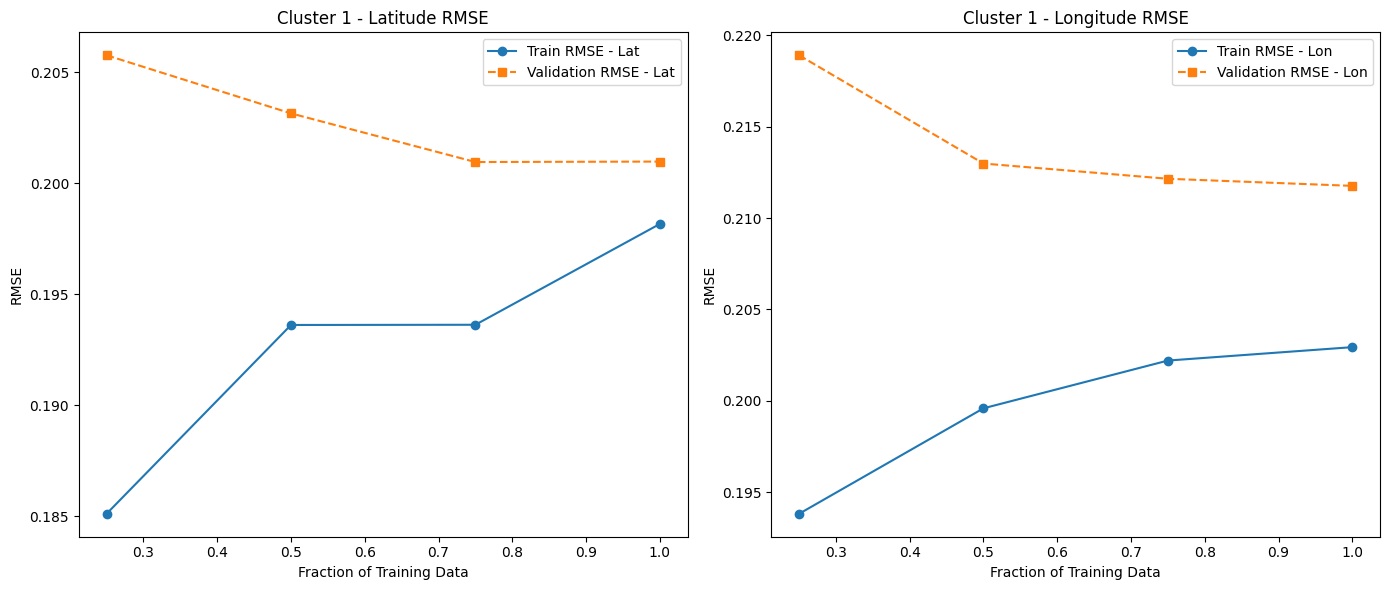

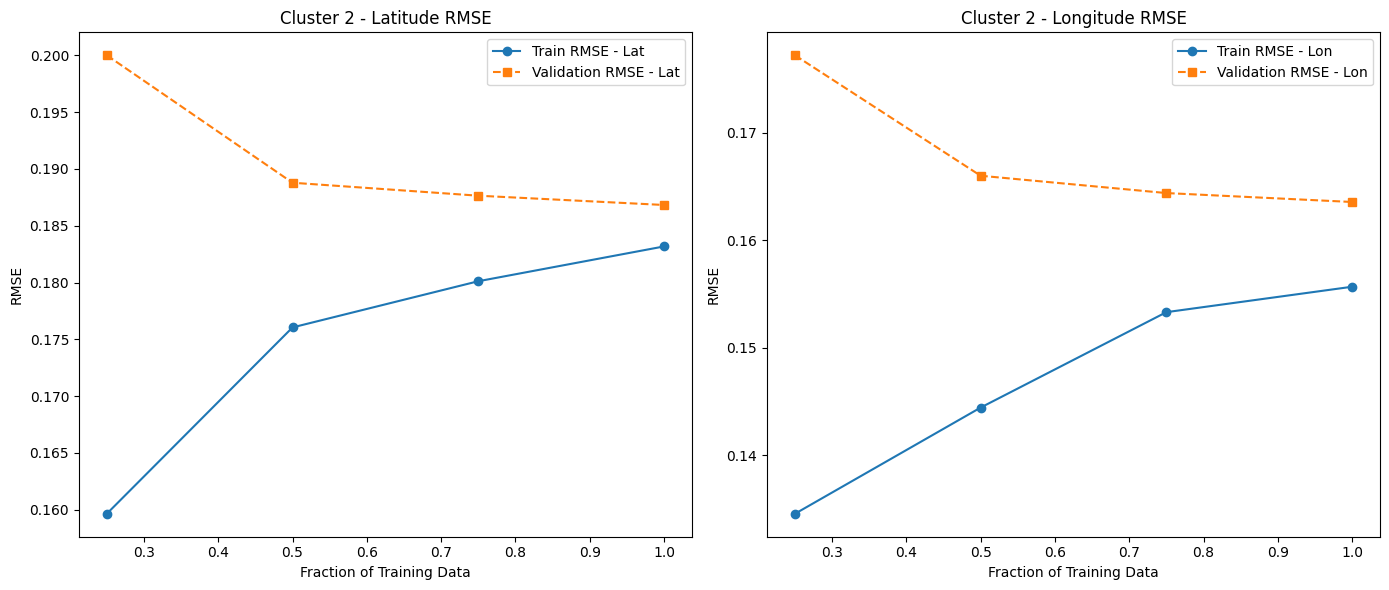

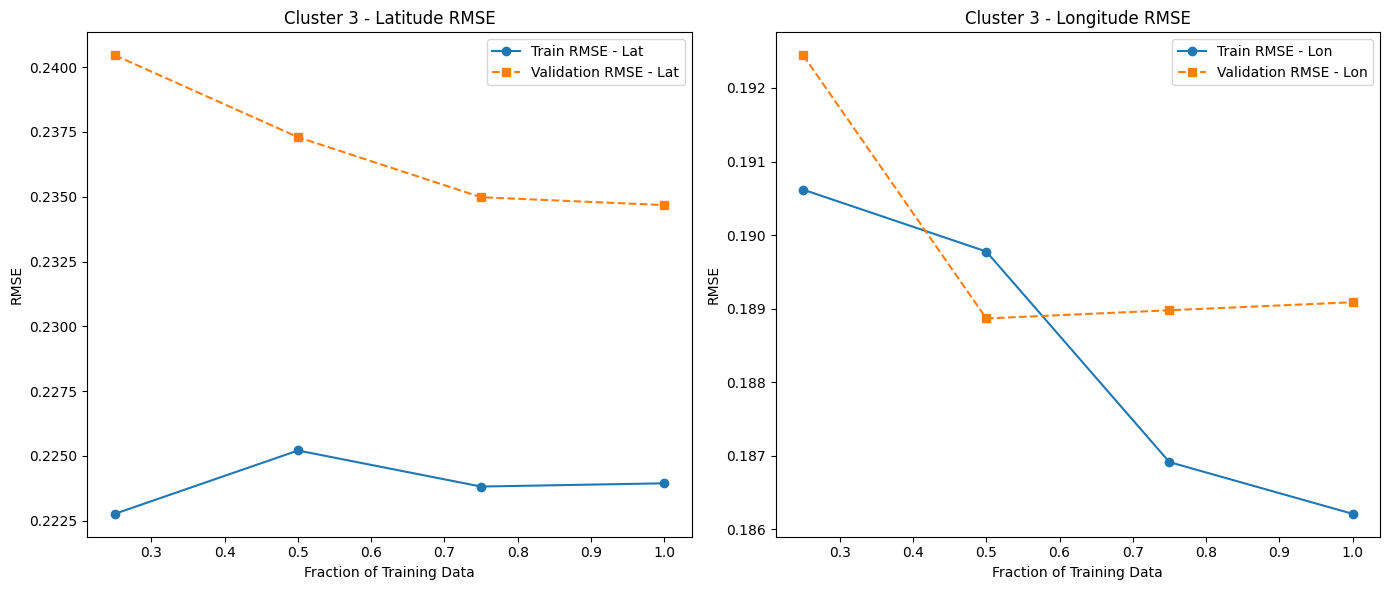

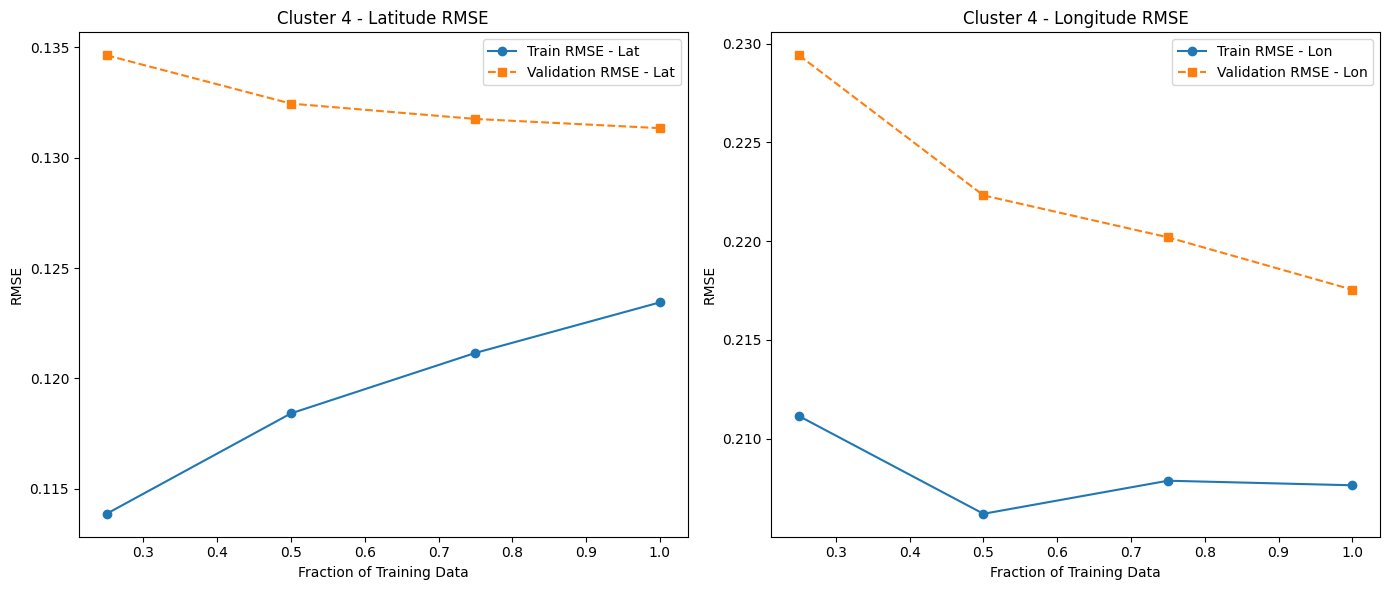

In [ ]:
def plot_rmse_results_per_cluster(results, fractions):

    for i, cluster_result in enumerate(results):
        plt.figure(figsize=(14, 6))

        # Latitude
        plt.subplot(1, 2, 1)
        plt.plot(fractions, cluster_result['train_rmse_lat'], 'o-', label='Train RMSE - Lat')
        plt.plot(fractions, cluster_result['val_rmse_lat'], 's--', label='Validation RMSE - Lat')
        plt.title(f'Cluster {i+1} - Latitude RMSE')
        plt.xlabel('Fraction of Training Data')
        plt.ylabel('RMSE')
        plt.legend()

        # Longitude
        plt.subplot(1, 2, 2)
        plt.plot(fractions, cluster_result['train_rmse_lon'], 'o-', label='Train RMSE - Lon')
        plt.plot(fractions, cluster_result['val_rmse_lon'], 's--', label='Validation RMSE - Lon')
        plt.title(f'Cluster {i+1} - Longitude RMSE')
        plt.xlabel('Fraction of Training Data')
        plt.ylabel('RMSE')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_rmse_results_per_cluster(results, fractions)


## Diferencia de Distancia en Metros (Radio)

In [ ]:
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt

# 1) Haversine meters
def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1 = np.radians(lat1); phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlmb/2)**2
    return R * (2*np.arctan2(np.sqrt(a), np.sqrt(1-a)))

def summarize_distance(errors_m):
    errs = np.asarray(errors_m)
    return {
        "count": errs.size,
        "mean_m": float(np.mean(errs)),
        "median_m": float(np.median(errs)),
        "rmse_m": float(np.sqrt(np.mean(errs**2))),
        "p90_m": float(np.percentile(errs, 90)),
        "p95_m": float(np.percentile(errs, 95)),
        "p99_m": float(np.percentile(errs, 99)),
        "max_m": float(np.max(errs)),
    }

# 2) Evaluate the FULL models you saved (per cluster)
def evaluate_full_models_distance(trained_models, cluster_data, scalers):
    """
    trained_models: list of (model_lat, model_lon) for each cluster (full-data models you saved)
    cluster_data: your existing list of dicts with X_val, Y_val_scaled
    scalers: the list of target MinMaxScaler objects aligned to clusters
    """
    per_cluster = []
    for i, ((model_lat, model_lon), cluster, scaler) in enumerate(zip(trained_models, cluster_data, scalers), start=1):
        X_val = cluster['X_val']
        Y_val_scaled = pd.DataFrame(cluster['Y_val_scaled'], columns=['LATITUD','LONGITUD'])

        # Predict in scaled space (since you trained on scaled targets)
        pred_lat_scaled = model_lat.predict(X_val)
        pred_lon_scaled = model_lon.predict(X_val)
        Y_pred_scaled = np.column_stack([pred_lat_scaled, pred_lon_scaled])

        # Inverse-transform both truth and preds back to real lat/lon
        Y_val_real = scaler.inverse_transform(Y_val_scaled)
        Y_pred_real = scaler.inverse_transform(Y_pred_scaled)

        lat_t, lon_t = Y_val_real[:,0], Y_val_real[:,1]
        lat_p, lon_p = Y_pred_real[:,0], Y_pred_real[:,1]

        dist_m = haversine_m(lat_t, lon_t, lat_p, lon_p)
        summary = summarize_distance(dist_m)
        per_cluster.append({"cluster": i, "summary": summary, "errors_m": dist_m})
    return per_cluster

# 3) (Optional) simple plot per cluster (median + p90 as bars)
def plot_full_model_distance_summaries(per_cluster):
    meds = [c["summary"]["median_m"] for c in per_cluster]
    p90s = [c["summary"]["p90_m"] for c in per_cluster]
    idxs = [c["cluster"] for c in per_cluster]

    plt.figure(figsize=(7,4))
    plt.plot(idxs, meds, 'o-', label='Median error (m)')
    plt.plot(idxs, p90s, 's--', label='P90 error (m)')
    plt.xlabel("Cluster")
    plt.ylabel("Metros")
    plt.title("Geodesic error – full models")
    plt.legend()
    plt.tight_layout()
    plt.show()


Cluster 1: {'count': 621, 'mean_m': 1468.855342560601, 'median_m': 1373.6583902486557, 'rmse_m': 1751.2549588212348, 'p90_m': 2731.1350388966734, 'p95_m': 3277.019038709077, 'p99_m': 4409.086031741342, 'max_m': 5068.114933647619}
Cluster 2: {'count': 465, 'mean_m': 1849.5342427525757, 'median_m': 1461.2716792234507, 'rmse_m': 2542.8275946185454, 'p90_m': 3890.232668244767, 'p95_m': 6223.190246658448, 'p99_m': 6847.527132586622, 'max_m': 7165.9849041427715}
Cluster 3: {'count': 907, 'mean_m': 2320.8222473459105, 'median_m': 2389.9296977946024, 'rmse_m': 2600.6647888591756, 'p90_m': 3768.6701296339356, 'p95_m': 4173.03511404084, 'p99_m': 4884.48682254974, 'max_m': 6177.762631138294}
Cluster 4: {'count': 453, 'mean_m': 1474.339019963836, 'median_m': 1529.7589072007554, 'rmse_m': 1752.7807111341572, 'p90_m': 2591.929442649419, 'p95_m': 2940.4979678741006, 'p99_m': 3628.7466506214755, 'max_m': 6299.709565639703}


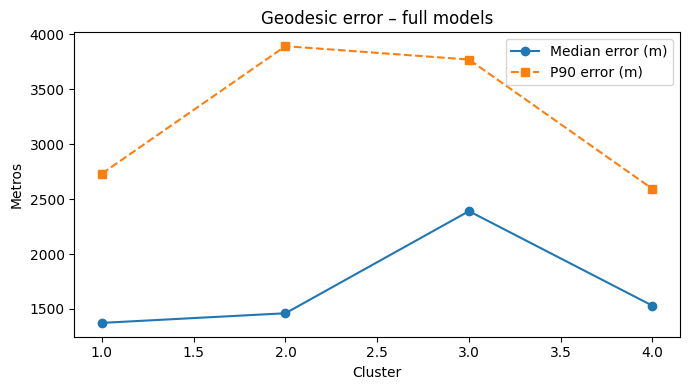

In [ ]:
per_cluster = evaluate_full_models_distance(trained_models, cluster_data, scalers)
for c in per_cluster:
    print(f"Cluster {c['cluster']}:", c["summary"])
plot_full_model_distance_summaries(per_cluster)


In [ ]:
trained_models = []
for i in range(1, len(cluster_data) + 1):
    lat_model_path = f'exported_models/cluster_{i}_model_lat.joblib'
    lon_model_path = f'exported_models/cluster_{i}_model_lon.joblib'
    model_lat = joblib.load(lat_model_path)
    model_lon = joblib.load(lon_model_path)
    trained_models.append((model_lat, model_lon))


# Selección de Fecha para Predecir

In [ ]:
# YYYY-MM-DD
date_str = "2025-10-04"

# Predicción de Coordenadas Segun la Fecha

## Importación de Modelos

In [ ]:
def load_cluster_bundle(export_dir, cluster_idx):
    """
    Carga artefactos de `exported_models/cluster_{cluster_idx}/`
    """
    cdir = os.path.join(export_dir, f"cluster_{cluster_idx}")
    bundle = {
        "model_lat": joblib.load(os.path.join(cdir, "model_lat.joblib")),
        "model_lon": joblib.load(os.path.join(cdir, "model_lon.joblib")),
        "scaler":    joblib.load(os.path.join(cdir, "target_scaler.joblib")),
        "x_columns": json.load(open(os.path.join(cdir, "x_columns.json"), "r", encoding="utf-8")),
        "rf_params": json.load(open(os.path.join(cdir, "rf_params.json"), "r", encoding="utf-8")),
        "rmse_log":  json.load(open(os.path.join(cdir, "rmse_log.json"), "r", encoding="utf-8")),
        "fractions": json.load(open(os.path.join(cdir, "fractions.json"), "r", encoding="utf-8")),
        "environment": json.load(open(os.path.join(cdir, "environment.json"), "r", encoding="utf-8"))
    }
    # feature_meta opcional
    fmeta_path = os.path.join(cdir, "feature_meta.json")
    if os.path.exists(fmeta_path):
        bundle["feature_meta"] = json.load(open(fmeta_path, "r", encoding="utf-8"))
    return bundle

## Formula de Preparación por cada 15 minutos

In [ ]:
def generate_time_intervals(date_str):
    """Generate 15-minute intervals for a given date."""
    intervals = []
    start_time = datetime.strptime(date_str, "%Y-%m-%d")
    for i in range(96):  # 96 intervals in a day (24 hours * 4 intervals per hour)
        intervals.append(start_time + timedelta(minutes=15 * i))
    return intervals

def convert_to_features(intervals):
    """Convert time intervals to features."""
    features = pd.DataFrame({
        'hour_sin': [np.sin(t.hour * (2 * np.pi / 24)) for t in intervals],
        'hour_cos': [np.cos(t.hour * (2 * np.pi / 24)) for t in intervals],
        'year': [t.year for t in intervals],
        'month': [t.month for t in intervals],
        'day': [t.day for t in intervals],
        'dayofweek': [t.weekday() for t in intervals],
        'is_weekend': [1 if t.weekday() in [5, 6] else 0 for t in intervals]
    })
    return features

def predict_coordinates_for_clusters(date_str, cluster_models, scalers):
    """
    Predict coordinates for all 15-minute intervals of a given date for each cluster,
    using a distinct scaler for each cluster. Also, concatenate latitude and longitude
    into a 'Coordenadas' string for each cluster.

    Parameters:
    - date_str: The date in "YYYY-MM-DD" format.
    - cluster_models: A list of tuples, each containing the trained latitude and longitude models for a cluster.
    - scalers: A list of MinMaxScaler instances used for inverse scaling predictions, one per cluster.

    Returns:
    - A DataFrame with the aggregated predictions for all clusters, including 'Coordenadas' columns.
    """
    intervals = generate_time_intervals(date_str)
    features = convert_to_features(intervals)

    aggregated_results = pd.DataFrame({
        'Day': date_str,
        'Time': [t.strftime("%H:%M") for t in intervals],
    })

    for i, ((model_lat, model_lon), scaler) in enumerate(zip(cluster_models, scalers), start=1):
        lat_pred_scaled = model_lat.predict(features)
        lon_pred_scaled = model_lon.predict(features)

        pred_scaled = np.vstack((lat_pred_scaled, lon_pred_scaled)).T
        pred_original_scale = scaler.inverse_transform(pred_scaled)

        aggregated_results[f'Cluster {i} Lat'] = pred_original_scale[:, 0]
        aggregated_results[f'Cluster {i} Lon'] = pred_original_scale[:, 1]

        # Concatenate latitude and longitude into 'Coordenadas' string using list comprehension
        aggregated_results[f'Coordenadas {i}'] = [
            f"{lat},{lon}" for lat, lon in zip(pred_original_scale[:, 0], pred_original_scale[:, 1])
        ]
    return aggregated_results



In [ ]:
# -----------------------------------------------------------------------------
# 1) Genera el grid de tiempos (cada 15 min) para una fecha YYYY-MM-DD
# -----------------------------------------------------------------------------
def build_inference_times(date_str: str, freq: str = "15min") -> pd.DataFrame:
    # Rango de 00:00:00 a 23:45:00 cada 15 min
    dt_index = pd.date_range(start=f"{date_str} 00:00:00", end=f"{date_str} 23:45:00", freq=freq)
    df = pd.DataFrame({
        "FECHA": [date_str] * len(dt_index),
        "HORA": dt_index.strftime("%H:%M:%S")  # HH:MM:SS para empatar tu parsing
    })
    return df

# -----------------------------------------------------------------------------
# 2) Prepara features de inferencia usando la MISMA ingeniería que en training
#    y reindexa contra la plantilla de columnas de X_train
# -----------------------------------------------------------------------------
def make_inference_features(date_str: str, X_template_columns: list, engineer_features_func, *,
                            add_shift_bins=True):
    """
    - date_str: 'YYYY-MM-DD'
    - X_template_columns: columnas usadas en entrenamiento (cluster['X_train'].columns)
    - engineer_features_func: por ejemplo engineer_features_v2
    Devuelve: DataFrame X_infer con MISMAS columnas y orden que X_template_columns
    """
    # 1) Grid de 15 min para ese día
    base_df = build_inference_times(date_str, freq="15min")  # FECHA, HORA

    # 2) Ingeniería de características, SIN forzar encoding de UBICACION (no la tenemos)
    X_eng, meta = engineer_features_func(
        base_df,
        onehot_small_cats=True,       # como en training
        encode_ubicacion="none",      # no tenemos UBICACION en inferencia
        add_shift_bins=add_shift_bins,
        drop_redundant_raw=True,
        keep_cols_extra=None
    )

    # 3) Reindexar a la plantilla (mismas columnas y orden). Llenar faltantes con 0.
    X_infer = X_eng.reindex(columns=X_template_columns, fill_value=0)

    # 4) Si la plantilla tenía columnas que no generamos (ej. UBICACION_FREQ),
    #    intenta imputarlas con el promedio de entrenamiento si es posible.
    #    (El caller puede pasarnos también ese promedio si lo desea; aquí
    #     tratamos de cubrir el caso más común)
    for col in X_template_columns:
        if col not in X_eng.columns:
            # Ya están en X_infer como 0 por el reindex. 0 está bien para one-hots.
            # Si detectaras columnas como 'UBICACION_FREQ', puedes reemplazar por un valor medio.
            pass

    return X_infer, meta

# -----------------------------------------------------------------------------
# 3) Predicción por clúster para TODO el día (cada 15 min) + desescalado
# -----------------------------------------------------------------------------
def predict_coordinates_for_clusters(date_str: str,
                                     cluster_models: list,   # [(model_lat, model_lon), ...]
                                     cluster_data: list,     # lista de dicts con 'X_train'
                                     scalers: list,          # lista de MinMaxScaler (uno por clúster)
                                     engineer_features_func, # ej. engineer_features_v2
                                     add_shift_bins=True) -> pd.DataFrame:
    """
    Devuelve un DataFrame con las predicciones por clúster y por intervalo de 15 minutos.
    Columnas: ['cluster','DT_15','HORA_15_* (si quieres conservarlas)','LAT_PRED','LON_PRED']
    """
    all_rows = []

    for i, ((model_lat, model_lon), cluster_dict, scaler) in enumerate(zip(cluster_models, cluster_data, scalers), start=1):
        # Plantilla de columnas del entrenamiento de este clúster
        X_template_cols = list(cluster_dict['X_train'].columns)

        # Construir features de inferencia alineadas a la plantilla
        X_infer, meta = make_inference_features(
            date_str=date_str,
            X_template_columns=X_template_cols,
            engineer_features_func=engineer_features_func,
            add_shift_bins=add_shift_bins
        )

        # Predicciones en espacio ESCALADO (así se entrenaron tus RF)
        pred_lat_s = model_lat.predict(X_infer)
        pred_lon_s = model_lon.predict(X_infer)
        Y_pred_s = np.column_stack([pred_lat_s, pred_lon_s])

        # Desescalar a lat/lon reales usando el scaler de ESTE clúster
        Y_pred_real = scaler.inverse_transform(Y_pred_s)
        lat_p, lon_p = Y_pred_real[:, 0], Y_pred_real[:, 1]

        # Recuperar un timestamp legible para cada fila (si tu engineer añade DT_15, úsalo;
        # si no, recreamos con FECHA+HORA en base_df)
        # Para ello, reconstruimos base_df con los mismos 96 pasos:
        base_df = build_inference_times(date_str, freq="15min")
        # Creamos DT_15 a partir de FECHA+HORA
        DT_15 = pd.to_datetime(base_df["FECHA"] + " " + base_df["HORA"])

        df_out = pd.DataFrame({
            "cluster": i,
            "DT_15": DT_15,
            "LAT_PRED": lat_p,
            "LON_PRED": lon_p
        })
        all_rows.append(df_out)

    return pd.concat(all_rows, ignore_index=True)


## Se Genera la Predicción

In [ ]:
aggregated_results = predict_coordinates_for_clusters(
    date_str=date_str,
    cluster_models=trained_models,
    cluster_data=cluster_data,
    scalers=scalers,
    engineer_features_func=engineer_features_v2,
    add_shift_bins=True
)

print(aggregated_results.head())


/tmp/ipython-input-2479201344.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_hora = pd.to_datetime(dfc["HORA"], errors="coerce")
/tmp/ipython-input-2479201344.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_hora = pd.to_datetime(dfc["HORA"], errors="coerce")
/tmp/ipython-input-2479201344.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_hora = pd.to_datetime(dfc["HORA"], errors="coerce")
/tmp/ipython-input-2479201344.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing i

   cluster               DT_15   LAT_PRED    LON_PRED
0        1 2025-10-04 00:00:00  25.771552 -100.245138
1        1 2025-10-04 00:15:00  25.772039 -100.245697
2        1 2025-10-04 00:30:00  25.772634 -100.245608
3        1 2025-10-04 00:45:00  25.772380 -100.245787
4        1 2025-10-04 01:00:00  25.772548 -100.245487


In [ ]:
aggregated_results.to_csv(f'pred_{date_str}.csv', index=False)

## Heatmap de Predicción

In [ ]:
# !pip install osmnx geopandas contextily shapely

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import osmnx as ox
from shapely.geometry import Point

# ----------------- Helpers -----------------
def _to_web_mercator_gdf(df_latlon: pd.DataFrame) -> gpd.GeoDataFrame:
    """Convierte LAT_PRED/LON_PRED a GeoDataFrame EPSG:3857 (metros)."""
    gdf = gpd.GeoDataFrame(
        df_latlon.dropna(subset=["LAT_PRED","LON_PRED"]).copy(),
        geometry=gpd.points_from_xy(df_latlon["LON_PRED"], df_latlon["LAT_PRED"]),
        crs="EPSG:4326"
    )
    return gdf.to_crs(epsg=3857)

def _grid_aggregate_counts(gdf_web: gpd.GeoDataFrame, bin_size_m: float = 100.0) -> gpd.GeoDataFrame:
    """
    Agrega puntos a una grilla métrica (EPSG:3857):
    - Cuantiza x,y a múltiplos de bin_size_m y cuenta ocurrencias.
    - Devuelve un GeoDataFrame con el centro de la celda y 'count'.
    """
    x = gdf_web.geometry.x.values
    y = gdf_web.geometry.y.values

    xbin = (np.floor(x / bin_size_m) * bin_size_m) + bin_size_m/2.0
    ybin = (np.floor(y / bin_size_m) * bin_size_m) + bin_size_m/2.0

    grid = (
        pd.DataFrame({"xbin": xbin, "ybin": ybin})
        .value_counts().reset_index(name="count")
    )
    grid_gdf = gpd.GeoDataFrame(
        grid, geometry=gpd.points_from_xy(grid["xbin"], grid["ybin"]), crs=gdf_web.crs
    )
    # Métricas extra
    grid_gdf["zscore"] = (grid_gdf["count"] - grid_gdf["count"].mean()) / (grid_gdf["count"].std(ddof=0) + 1e-9)
    return grid_gdf

def _radius_from_count(count_series: pd.Series, base_radius_m: float = 60.0, max_radius_m: float = 300.0):
    """
    Escala de radios en metros usando raíz (crece suave): r = base * sqrt(count/mediana).
    Limita a max_radius_m y evita división por cero.
    """
    med = np.median(count_series.values) if len(count_series) else 1.0
    med = med if med > 0 else 1.0
    r = base_radius_m * np.sqrt(count_series.values / med)
    return np.clip(r, base_radius_m * 0.6, max_radius_m)

# ----------------- Plot principal -----------------
def plot_bubble_heatmap_on_apodaca(
    aggregated_results: pd.DataFrame,
    cluster_id: int | None = None,       # None = todos los clústeres juntos
    bin_size_m: float = 100.0,           # tamaño de celda de agregación (m)
    base_radius_m: float = 60.0,         # radio base (m)
    max_radius_m: float = 300.0,         # radio máximo (m)
    color_metric: str = "count",         # "count" o "zscore"
    cmap: str = "inferno",
    alpha: float = 0.60,
    edgecolor: str = "k",
    edgealpha: float = 0.25,
    title: str | None = None
):
    """
    Dibuja mapa de Apodaca + burbujas (círculos) coloreadas y escaladas según frecuencia/sobreexposición.
    - aggregated_results: columnas ['cluster','DT_15','LAT_PRED','LON_PRED'].
    - Si 'cluster_id' se especifica, filtra a ese clúster.
    """
    # 1) Filtrar clúster (opcional)
    df = aggregated_results.copy()
    if cluster_id is not None:
        df = df.loc[df["cluster"] == cluster_id].copy()
        if df.empty:
            print(f"[Aviso] no hay datos para cluster {cluster_id}."); return

    # 2) Puntos a EPSG:3857 y polígono Apodaca
    gdf_web = _to_web_mercator_gdf(df)
    if gdf_web.empty:
        print("[Aviso] no hay puntos válidos para el mapa."); return

    apodaca_web = ox.geocode_to_gdf("Apodaca, Nuevo León, México").to_crs(epsg=3857)

    # 3) Agregación por grilla + radios
    grid_gdf = _grid_aggregate_counts(gdf_web, bin_size_m=bin_size_m)
    if grid_gdf.empty:
        print("[Aviso] grilla vacía tras agregación."); return
    grid_gdf["radius_m"] = _radius_from_count(grid_gdf["count"], base_radius_m, max_radius_m)

    # 4) Métrica de color
    metric = grid_gdf[color_metric].values if color_metric in ("count", "zscore") else grid_gdf["count"].values

    # 5) Construir “burbujas” como buffers en metros
    bubbles = grid_gdf.copy()
    bubbles["geometry"] = bubbles.geometry.buffer(bubbles["radius_m"])

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10,10))
    # Límite municipal
    apodaca_web.boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=2, label="Apodaca")

    # Burbujas coloreadas por métrica
    bubbles.plot(
        ax=ax, column=(color_metric if color_metric in ("count","zscore") else "count"),
        cmap=cmap, alpha=alpha, edgecolor=edgecolor, linewidth=0.5, zorder=3, legend=True
    )

    # Basemap OSM
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Estética
    if title is None:
        title = "Burbujas por frecuencia – Apodaca" if cluster_id is None else f"Cluster {cluster_id} – Burbujas por frecuencia"
    ax.set_title(title, fontsize=14)
    ax.set_aspect("equal", adjustable="box")
    ax.set_axis_off()
    # Leyenda simple de tamaños (opcional)
    # Puedes agregar scatter proxies si quieres mostrar radios ~ conteos
    plt.tight_layout()
    plt.show()


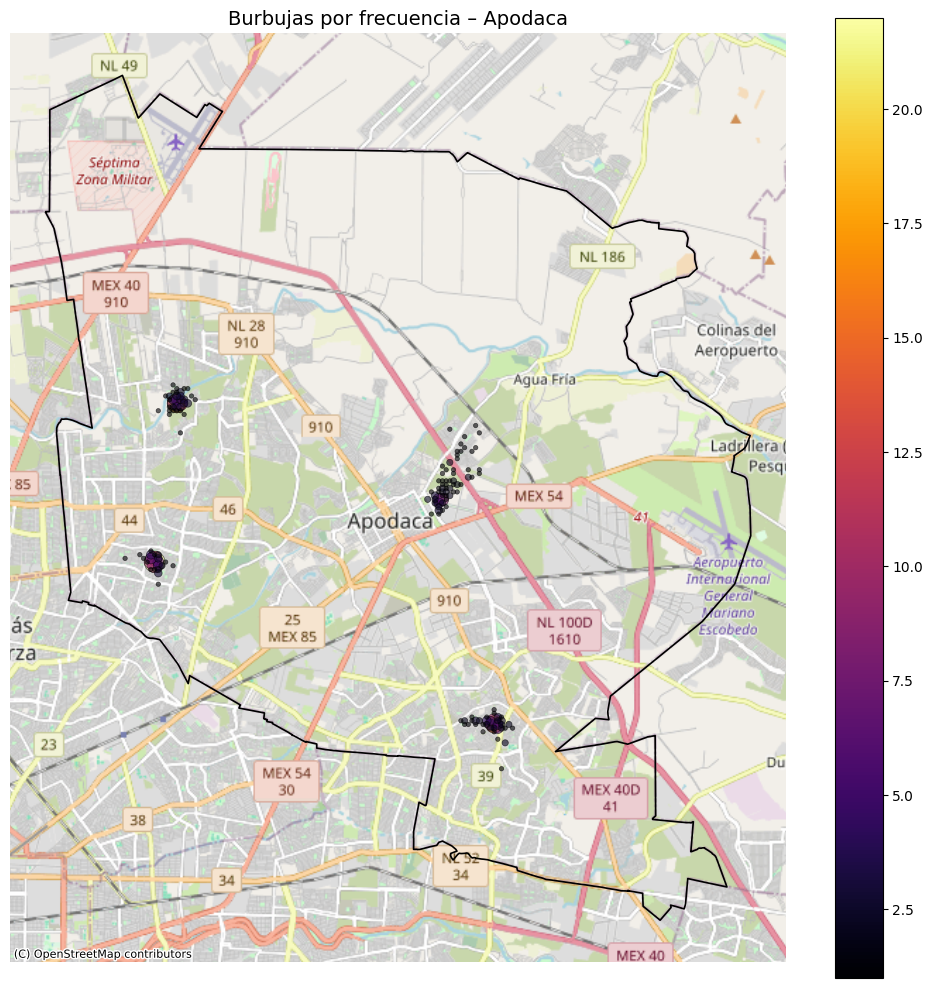

In [ ]:
# 1) Todos los clústeres juntos, celdas de 100 m, color por count
plot_bubble_heatmap_on_apodaca(
    aggregated_results,
    cluster_id=None,
    bin_size_m=100,
    base_radius_m=60,
    max_radius_m=300,
    color_metric="count",
    cmap="inferno"
)



Este mapa muestra la concentración de incidentes predichos en el municipio de Apodaca para el día 4 de octubre del 2025, representados como burbujas cuyo tamaño refleja la frecuencia y cuyo color indica la intensidad (más claro = más denso).

**Hallazgos principales**:
- Se detectan **zonas de alta recurrencia** en el centro de Apodaca y a lo largo del corredor vial **MEX 54**, lo que sugiere focos críticos de actividad.
- En contraste, varias áreas periféricas presentan **actividad dispersa o aislada**, con baja densidad de puntos.

**Interpretación**:
La presencia de hotspots en avenidas principales puede relacionarse con la **alta movilidad urbana y concentración poblacional** en dichas zonas. Estos patrones pueden señalar áreas de mayor riesgo o necesidad de servicios.

**Decisiones sugeridas**:
- **Asignar más recursos** (ej. patrullas, ambulancias) en los hotspots identificados.
- **Monitorear de forma preventiva** corredores críticos para anticipar incidentes.
- **Comparar clusters específicos** (usando el parámetro `cluster_id`) para diferenciar patrones de distintos tipos de eventos.

## Ruta de Ambulancias

In [ ]:
# !pip install osmnx geopandas contextily shapely

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import osmnx as ox
from shapely.geometry import Point, LineString

# ----------------------------
# Build route geometries (lines) from aggregated_results
# ----------------------------
def routes_from_aggregated(aggregated_results: pd.DataFrame):
    """
    Returns three GeoDataFrames in EPSG:4326:
    - routes_gdf:   one LineString per cluster (time-ordered)
    - starts_gdf:   start point per cluster
    - ends_gdf:     end point per cluster
    """
    routes, starts, ends = [], [], []

    for cid, dfc in aggregated_results.groupby("cluster"):
        dfc = dfc.dropna(subset=["LAT_PRED","LON_PRED","DT_15"]).copy()
        if not pd.api.types.is_datetime64_any_dtype(dfc["DT_15"]):
            dfc["DT_15"] = pd.to_datetime(dfc["DT_15"], errors="coerce")
        dfc = dfc.sort_values("DT_15")

        if dfc.empty:
            continue

        coords = list(zip(dfc["LON_PRED"].values, dfc["LAT_PRED"].values))
        line = LineString(coords)

        routes.append({"cluster": int(cid), "geometry": line})
        starts.append({"cluster": int(cid), "geometry": Point(coords[0])})
        ends.append({"cluster": int(cid), "geometry": Point(coords[-1])})

    routes_gdf = gpd.GeoDataFrame(routes, crs="EPSG:4326")
    starts_gdf = gpd.GeoDataFrame(starts, crs="EPSG:4326")
    ends_gdf   = gpd.GeoDataFrame(ends,   crs="EPSG:4326")
    return routes_gdf, starts_gdf, ends_gdf

# ----------------------------
# Plot all routes together on Apodaca map
# ----------------------------
def plot_routes_on_apodaca_all(aggregated_results: pd.DataFrame, basemap=True, linewidth=2):
    # Apodaca polygon
    apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")
    apodaca_web = apodaca.to_crs(epsg=3857)

    # Routes & endpoints
    routes, starts, ends = routes_from_aggregated(aggregated_results)
    if routes.empty:
        print("No routes to plot."); return

    routes_web = routes.to_crs(epsg=3857)
    starts_web = starts.to_crs(epsg=3857)
    ends_web   = ends.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10,10))
    apodaca_web.boundary.plot(ax=ax, color="black", linewidth=1.2, label="Apodaca")

    # color by cluster
    cmap = plt.get_cmap("tab10")
    for _, row in routes_web.iterrows():
        color = cmap((row["cluster"]-1) % 10)
        gpd.GeoDataFrame([row], crs=routes_web.crs).plot(ax=ax, linewidth=linewidth, color=color, label=f"Cluster {row['cluster']}")

    # start (circle) and end (X)
    starts_web.plot(ax=ax, color="lime", markersize=30, label="Start")
    ends_web.plot(ax=ax, color="red", markersize=30, marker="X", label="End")

    if basemap:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title("Cluster routes – Apodaca", fontsize=14)
    ax.set_axis_off()

    # deduplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.tight_layout()
    plt.show()

# ----------------------------
# Plot one figure per cluster on Apodaca map
# ----------------------------
def plot_routes_on_apodaca_per_cluster(aggregated_results: pd.DataFrame, basemap=True, linewidth=2):
    apodaca = ox.geocode_to_gdf("Apodaca, Nuevo León, México")
    apodaca_web = apodaca.to_crs(epsg=3857)

    routes, starts, ends = routes_from_aggregated(aggregated_results)
    if routes.empty:
        print("No routes to plot."); return

    routes_web = routes.to_crs(epsg=3857)
    starts_web = starts.to_crs(epsg=3857)
    ends_web   = ends.to_crs(epsg=3857)

    for cid in sorted(routes_web["cluster"].unique()):
        fig, ax = plt.subplots(figsize=(9,9))
        apodaca_web.boundary.plot(ax=ax, color="black", linewidth=1.2)
        routes_web[routes_web["cluster"]==cid].plot(ax=ax, linewidth=linewidth, color="steelblue")
        starts_web[starts_web["cluster"]==cid].plot(ax=ax, color="lime", markersize=35)
        ends_web[ends_web["cluster"]==cid].plot(ax=ax, color="red",  markersize=35, marker="X")

        if basemap:
            ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

        ax.set_title(f"Cluster {int(cid)} – Route (15-min steps)", fontsize=14)
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()


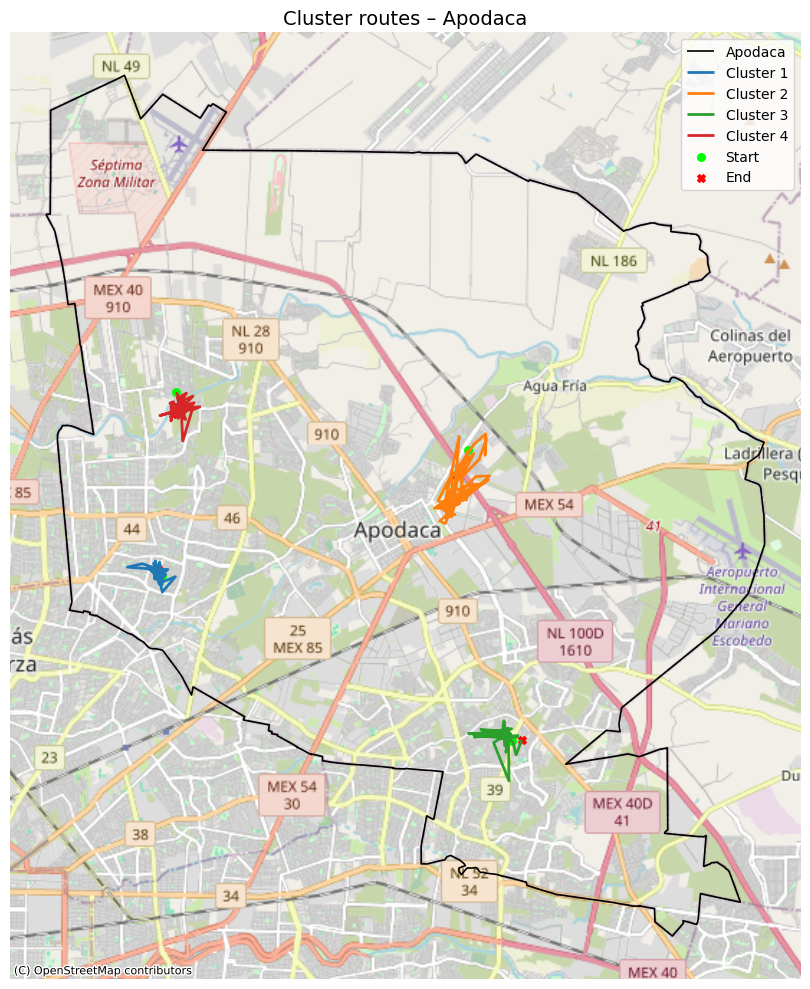

In [ ]:
# All routes together
plot_routes_on_apodaca_all(aggregated_results, basemap=True, linewidth=2)

Rutas por Clúster en Apodaca

El siguiente mapa muestra la secuencia de trayectorias predichas en distintos clústeres dentro del municipio de Apodaca.  
Cada línea de color representa un clúster, con el círculo verde como punto de inicio y la X roja como punto final.

---

#### Hallazgos:
- **Cluster 1 (azul, oeste):**  
  Patrón compacto y aislado en un sector específico.  
  Podría reflejar movilidad localizada o baja actividad relativa.

- **Cluster 2 (naranja, centro):**  
  Trayectorias cortas y densas en la zona más urbana de Apodaca.  
  Indica movilidad intensa en áreas comerciales e industriales.

- **Cluster 3 (rojo, noroeste):**  
  Rutas cortas en el corazón de la ciudad.  
  Posible congestión y alta densidad en trayectorias breves.

- **Cluster 4 (verde, sur):**  
  Recorridos más amplios que conectan áreas residenciales del sur con zonas céntricas.  
  Representa trayectorias de mediana distancia.

---

#### Interpretación
Cada clúster refleja un tipo distinto de movilidad en Apodaca:
- Clústeres densos y cortos: zonas céntricas con alto tránsito.  
- Clústeres largos y dispersos: conexiones periféricas y residenciales.  
- Clústeres aislados: movilidad reducida en áreas delimitadas.  

---

#### Acciones sugeridas
- **Cluster 2:** reforzar recursos en el centro urbano para atender alta concentración de trayectorias.  
- **Cluster 4:** planificar cobertura extendida para trayectorias largas que conectan periferia y centro.  
- **Cluster 1:** monitoreo focalizado en un área específica con movilidad reducida.  
- **Cluster 3:** considerar estrategias de gestión en áreas con alta densidad y recorridos cortos.  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cluster_trajectory(aggregated_results: pd.DataFrame, cluster_id: int,
                            annotate_ends: bool = True):
    """
    Draws a time-ordered trajectory for one cluster:
    - Sorts by DT_15
    - Plots line + markers in lon/lat
    """
    dfc = aggregated_results.loc[aggregated_results["cluster"] == cluster_id].copy()
    dfc = dfc.dropna(subset=["LAT_PRED", "LON_PRED", "DT_15"])
    if dfc.empty:
        print(f"[Aviso] No data for cluster {cluster_id}.");
        return

    # Ensure datetime & sort
    if not pd.api.types.is_datetime64_any_dtype(dfc["DT_15"]):
        dfc["DT_15"] = pd.to_datetime(dfc["DT_15"], errors="coerce")
    dfc = dfc.sort_values("DT_15")

    # Plot
    plt.figure(figsize=(6,6))
    plt.plot(dfc["LON_PRED"].values, dfc["LAT_PRED"].values, marker='o')
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    t0 = dfc["DT_15"].iloc[0]; t1 = dfc["DT_15"].iloc[-1]
    plt.title(f"Cluster {cluster_id} – Trajectory\n{t0} → {t1}")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    # Mark start/end
    if annotate_ends:
        plt.scatter(dfc["LON_PRED"].iloc[0],  dfc["LAT_PRED"].iloc[0],  marker='o', s=60)
        plt.scatter(dfc["LON_PRED"].iloc[-1], dfc["LAT_PRED"].iloc[-1], marker='X', s=80)

    plt.tight_layout()
    plt.show()


def plot_all_clusters_trajectories(aggregated_results: pd.DataFrame, annotate_ends: bool = True):
    """
    Loops over clusters and makes one figure per cluster.
    """
    clusters = sorted(aggregated_results["cluster"].dropna().unique())
    for cid in clusters:
        plot_cluster_trajectory(aggregated_results, int(cid), annotate_ends=annotate_ends)


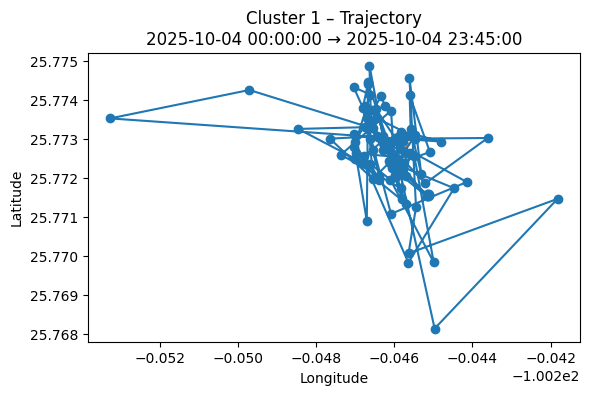

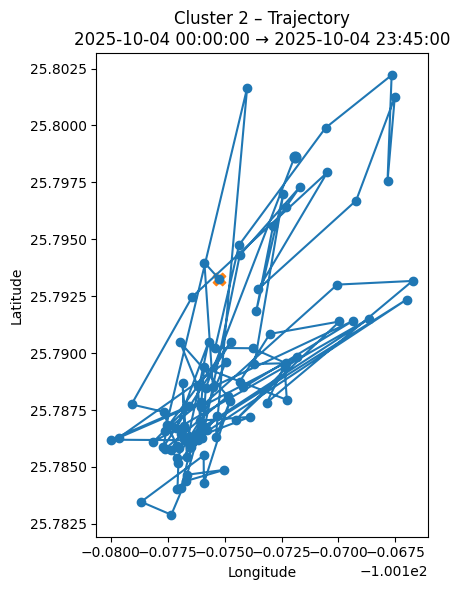

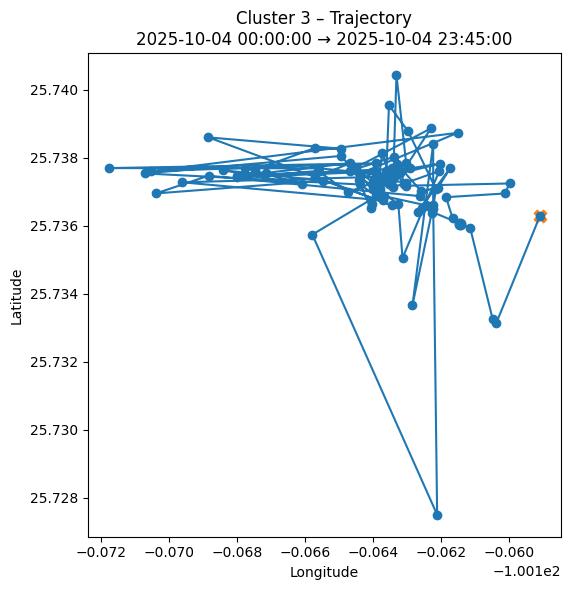

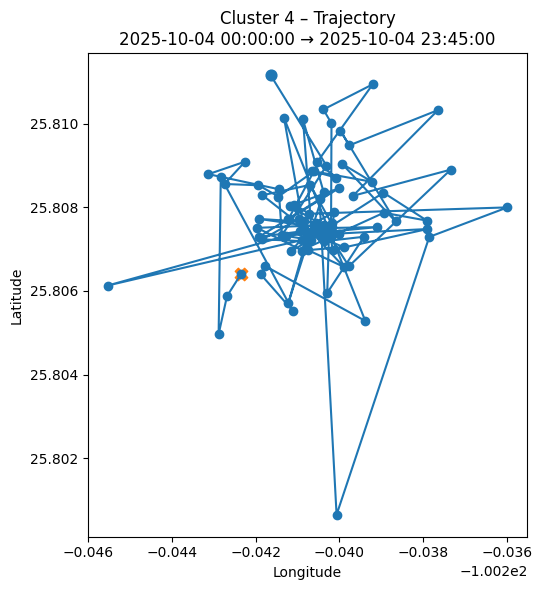

In [ ]:
# One figure per cluster
plot_all_clusters_trajectories(aggregated_results, annotate_ends=True)

# Or just one cluster:
# plot_cluster_trajectory(aggregated_results, cluster_id=1, annotate_ends=True)
